In [1]:
import pickle
from distutils.dir_util import copy_tree
with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/extra_scripts/src.py') as f:
    exec(f.read())
torch.manual_seed(1)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set(style="whitegrid")
#from lifelines import CoxPHFitter
#from captum.attr import DeepLiftShap

/home/jislam/.local/lib/python3.10/site-packages/gosip/__init__.py:5: FutureWarning: In the future `np.ulong` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'ulong'):


In [2]:
min_optuna=10
hyperparam_epochs=200 #max per trial(note that we add burn in inside the loop
hyperparam_trials=100 #number of trials for each model.
patience=5
burn_in=10
num_epochs=1000
k=100
bsize=2048
zi=False
validation_ratio=0.2 #10% of dataset is kept for validation during training. we do not use a testing set since we're only interested in what it learned not generalizability.


main_path="/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/"
dataLocation="/home/jislam/Documents/gits/scRNAseq_datasets/hpap_batch_corrected.final3k.h5ad"
filter_by="cell_type"
categories_to_keep = 8 #number of cell types I want to keep in the model sorted by decreasing cell count, can use all but only so much weighted losses can do...
category_labels=["cell_disease"] # See adata.obs.columns for what categories you can use here. Specify which columns to one-hot-encode and use to inform the models. cell_disease is generated for the interaction.

group_a=["beta_cell_T2D"]
group_b=["beta_cell_Control"]
shared_filter =None

single_cell_data="hpapnb3k"



outdir=single_cell_data.replace(" ", "_")
if not os.path.exists(outdir):
    os.makedirs(outdir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

adata=sc.read_h5ad(dataLocation)
adata.obs['cell_type']=adata.obs['cell_type'].str.replace(" ", "_", regex=False)
adata=adata[adata.obs["disease_state"]!="AAB"]
adata=adata[adata.obs["disease_state"]!="T1D"]
adata=adata[adata.obs["cell_type"]!="unknown"]
adata= adata[adata.obs['cell_type'].isin(['alpha_cell', 'delta_cell', 'beta_cell', 'PP_cell','acinar_cell'])]#, 'precursor_alpha_beta_cell'
#adata.obs.loc[adata.obs['cell_type']=='precursor_alpha_beta_cell','cell_type']="precursor_cell"

adata.obs["cell_disease"]=adata.obs["cell_type"].astype(str) + '_' + adata.obs["disease_state"].astype(str)

one_hot_labels, num_categories= gosip.one_hot_encode_combinations(adata.obs, category_labels)
adata.one_hot_labels= one_hot_labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

adata.obs['cell_disease'].unique()

/tmp/ipykernel_338782/2348216859.py:41: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cell_disease"]=adata.obs["cell_type"].astype(str) + '_' + adata.obs["disease_state"].astype(str)


array(['alpha_cell_Control', 'delta_cell_Control', 'beta_cell_Control',
       'acinar_cell_Control', 'PP_cell_Control', 'alpha_cell_T2D',
       'beta_cell_T2D', 'acinar_cell_T2D', 'delta_cell_T2D',
       'PP_cell_T2D'], dtype=object)

In [3]:
adata

AnnData object with n_obs × n_vars = 131378 × 3000
    obs: 'donor_id', 'cell_type', 'assay', 'sex', 'age', 'race', 'disease_state', 'cell_disease', 'n_genes'
    uns: 'cell_disease_colors', 'cell_type_colors', 'disease_state_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
import numpy as np

# get dense matrix
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X

# gene‐wise moments
mu = X.mean(axis=0)
sigma2 = X.var(axis=0)
# skip genes with no overdispersion
#mask = sigma2 > mu
#mu, sigma2 = mu[mask], sigma2[mask]

# NB parameters
r = mu**2 / (sigma2 - mu)
p = r / (r + mu)

# expected vs observed zero‐fractions
exp_zero = p**r
obs_zero = (X == 0).mean(axis=0)

# which genes exceed expectation?
inflated = obs_zero > exp_zero
print(f"{inflated.mean()*100:.1f}% of genes have more zeros than expected")


/tmp/ipykernel_338782/3299650834.py:18: RuntimeWarning: invalid value encountered in power
  exp_zero = p**r


0.0% of genes have more zeros than expected


array([[<Axes: title={'center': '0'}>]], dtype=object)

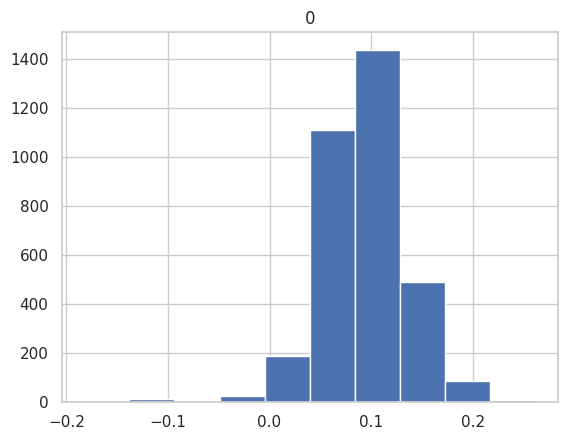

In [5]:
pd.DataFrame(adata[adata.obs['cell_disease']=="delta_cell_Control"].X[:,adata.var.index=="SST"]).hist()

In [6]:


gene_pick='INS'

print(pd.DataFrame(adata.X[adata.obs['cell_disease']=='beta_cell_Control',adata.var.index==gene_pick]).mean())
print(pd.DataFrame(adata.X[adata.obs['cell_disease']=='beta_cell_T2D',adata.var.index==gene_pick]).mean())


0    0.193157
dtype: float64
0    0.212035
dtype: float64


In [7]:
adata.X[adata.obs['cell_disease']=='beta_cell_control',adata.var.index==gene_pick]

array([], dtype=float64)

In [8]:

sc.tl.rank_genes_groups(adata, groupby='cell_disease', groups=group_a, reference=group_b[0], method='t-test', use_raw=False,rankby_abs=True,key_added="cure_T2D")
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save=outdir+"basic_test.png")
sc.tl.rank_genes_groups(adata, groupby='cell_disease', groups=group_b, reference=group_a[0], method='t-test', use_raw=False,rankby_abs=True,key_added="cause_T2D")
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save=outdir+"basic_test.png")

/home/jislam/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jislam/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


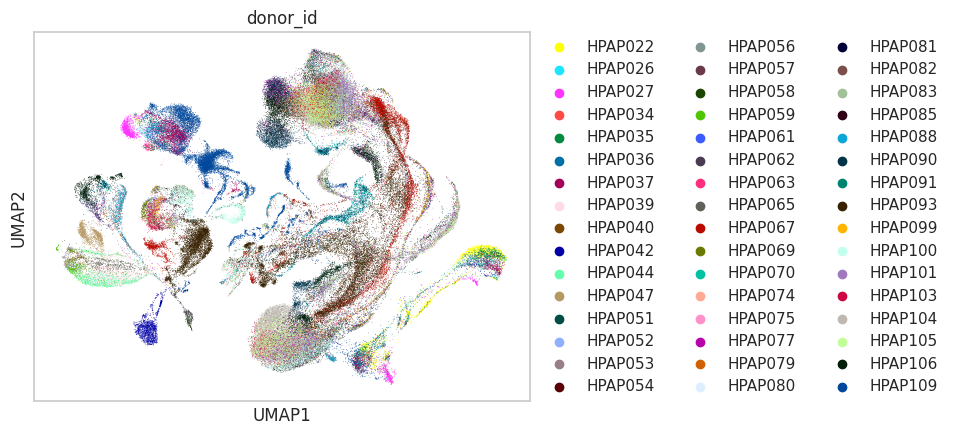

In [9]:
sc.pl.umap(adata, color=["donor_id"])


/tmp/ipykernel_338782/3097810814.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]


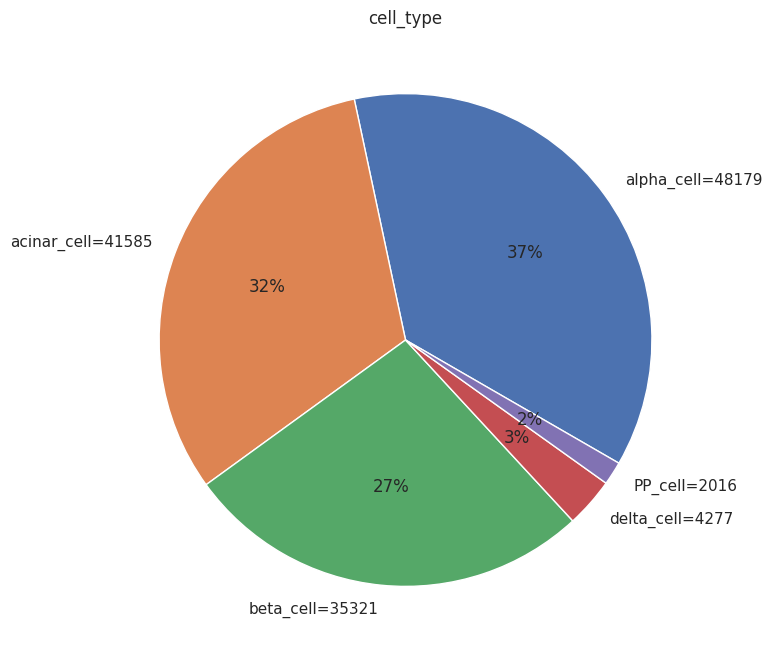

/tmp/ipykernel_338782/3097810814.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]


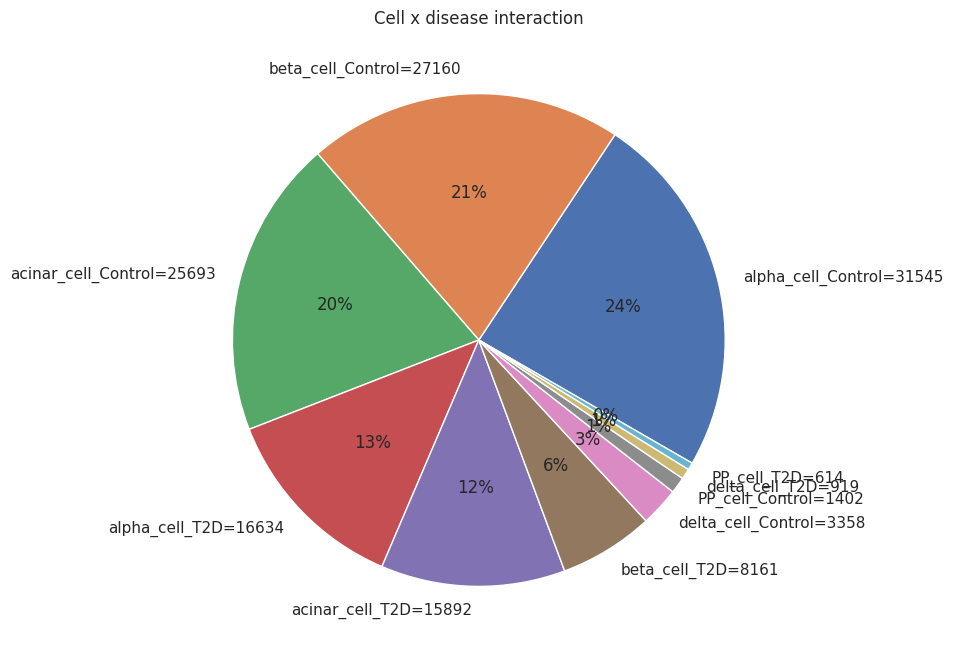

In [10]:
# Extract the column data
column_data = adata.obs[filter_by]

# Count the occurrences of each unique value
value_counts = column_data.value_counts()
value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%.0f%%', startangle=-30)
plt.title(filter_by)
plt.show()

# Extract the column data
column_data = adata.obs['cell_disease']

# Count the occurrences of each unique value
value_counts = column_data.value_counts()
value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%.0f%%', startangle=-30)
plt.title('Cell x disease interaction')
plt.show()




In [11]:
adata.X.max()

0.5735327634320841

In [12]:
adata.obs

donor_id    cell_type      assay     sex age       race  \
AAACCTGAGGTGTGGT-2   HPAP022   alpha_cell  10x 3' v2  female  39  Caucasian   
AAACCTGCACGCCAGT-2   HPAP022   alpha_cell  10x 3' v2  female  39  Caucasian   
AAACCTGCAGTCGATT-2   HPAP022   alpha_cell  10x 3' v2  female  39  Caucasian   
AAACCTGTCACCCTCA-2   HPAP022   alpha_cell  10x 3' v2  female  39  Caucasian   
AAACCTGTCCCGACTT-2   HPAP022   alpha_cell  10x 3' v2  female  39  Caucasian   
...                      ...          ...        ...     ...  ..        ...   
TTTGTTGCATGGGCAA-67  HPAP109  acinar_cell  10x 3' v3  female  59   Hispanic   
TTTGTTGGTAATGCTC-67  HPAP109  acinar_cell  10x 3' v3  female  59   Hispanic   
TTTGTTGGTCGTTGCG-67  HPAP109  acinar_cell  10x 3' v3  female  59   Hispanic   
TTTGTTGGTTTAGACC-67  HPAP109  acinar_cell  10x 3' v3  female  59   Hispanic   
TTTGTTGTCGCTCTAC-67  HPAP109  acinar_cell  10x 3' v3  female  59   Hispanic   

                    disease_state        cell_disease  n_genes  
AAACCTGAGGTGTGGT-2        Control  alpha_cell_Control     2931  
AAACCTGCACGCCAGT-2        Control  alpha_cell_Control     1172  
AAACCTGCAGTCGATT-2        Control  alpha_cell_Control     4331  
AAACCTGTCACCCTCA-2        Control  alpha_cell_Control     4206  
AAACCTGTCCCGACTT-2        Control  alpha_cell_Control      803  
...                           ...                 ...      ...  
TTTGTTGCATGGGCAA-67           T2D     acinar_cell_T2D     3017  
TTTGTTGGTAATGCTC-67           T2D     acinar_cell_T2D      271  
TTTGTTGGTCGTTGCG-67           T2D     acinar_cell_T2D     3759  
TTTGTTGGTTTAGACC-67           T2D     acinar_cell_T2D      355  
TTTGTTGTCGCTCTAC-67           T2D     acinar_cell_T2D      308  

[131378 rows x 9 columns]

/tmp/ipykernel_338782/2128370382.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index.str.replace("_", " "), ax=ax2, palette="Blues_r")
/tmp/ipykernel_338782/2128370382.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index.str.replace("_", " "), ax=ax3, palette="Reds_r")


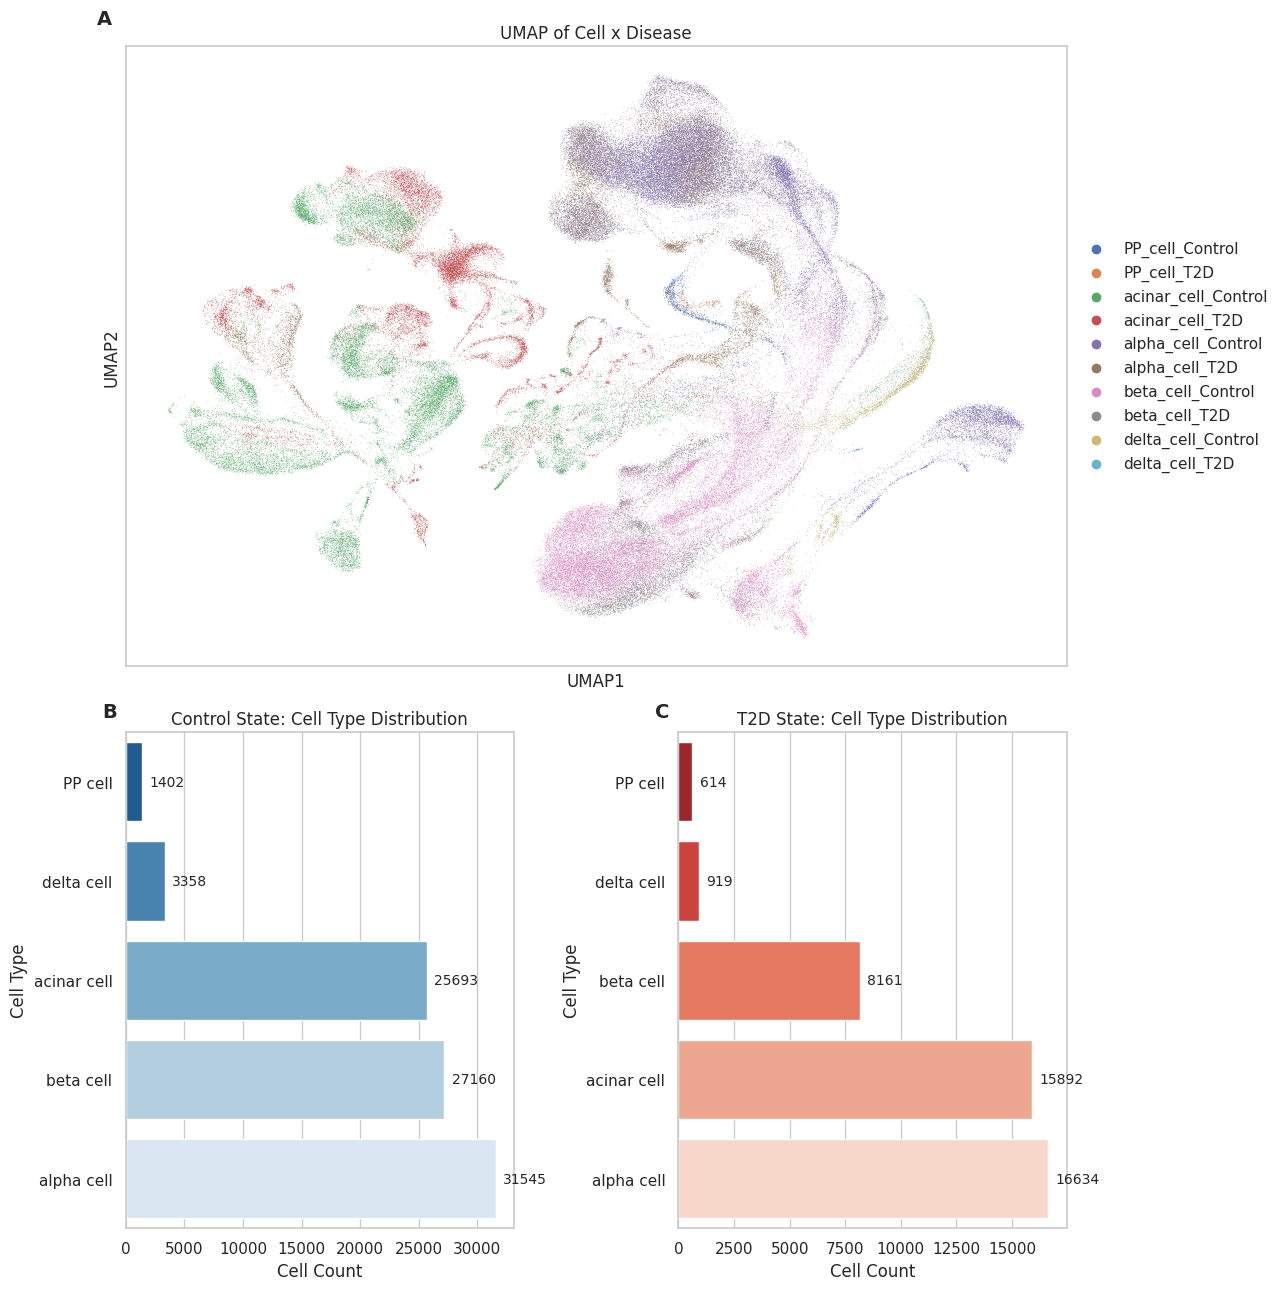

In [13]:
'''
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.8], width_ratios=[1, 1], figure=fig)

# Function to add labels on bars
def add_bar_labels(ax, values):
    for i, v in enumerate(values):
        ax.text(v + max(values) * 0.02, i, str(v), va='center', fontsize=10)  # Shift label slightly to the right

# Function to add subplot labels (A, B, C)
def add_subplot_label(ax, label,x_pos=0.02,y_pos=0.99):
    ax.text(x_pos,y_pos, label, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# --- PLOT 1: UMAP (Spanning the full first row) ---
ax1 = fig.add_subplot(gs[0, :])  # Full row for UMAP
sc.pl.umap(adata, color=["cell_disease"], ax=ax1, show=False)
ax1.set_title("UMAP of Cell x Disease")
add_subplot_label(ax1, "A",x_pos=-0.03,y_pos=1.06)  # Add label "A"

# --- PLOT 2: Bar Chart for Control State ---
ax2 = fig.add_subplot(gs[1, 0])
column_data = adata.obs.loc[adata.obs['disease_state'] == "Control", 'cell_type']
value_counts = column_data.value_counts(ascending=True)

sns.barplot(x=value_counts.values, y=value_counts.index.str.replace("_", " "), ax=ax2, palette="Blues_r")
ax2.set_title("Control State: Cell Type Distribution")
ax2.set_xlabel("Cell Count")
ax2.set_ylabel("Cell Type")
add_bar_labels(ax2, value_counts.values)
add_subplot_label(ax2, "B",x_pos=-0.06,y_pos=1.06)  # Add label "B"

# --- PLOT 3: Bar Chart for T2D State ---
ax3 = fig.add_subplot(gs[1, 1])
column_data = adata.obs.loc[adata.obs['disease_state'] == "T2D", 'cell_type']
value_counts = column_data.value_counts(ascending=True)

# Ensure the last element is removed safely
if value_counts.shape[0] > 1:
    value_counts = value_counts

sns.barplot(x=value_counts.values, y=value_counts.index.str.replace("_", " "), ax=ax3, palette="Reds_r")
ax3.set_title("T2D State: Cell Type Distribution")
ax3.set_xlabel("Cell Count")
ax3.set_ylabel("Cell Type")
add_bar_labels(ax3, value_counts.values)
add_subplot_label(ax3, "C",x_pos=-0.06,y_pos=1.06)  # Add label "C"

# Adjust layout
plt.tight_layout()
plt.show()
fig.savefig(f'{main_path}{single_cell_data}/hpapnb-developmental-merge.png')
'''

/tmp/ipykernel_338782/1961269736.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_338782/1961269736.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


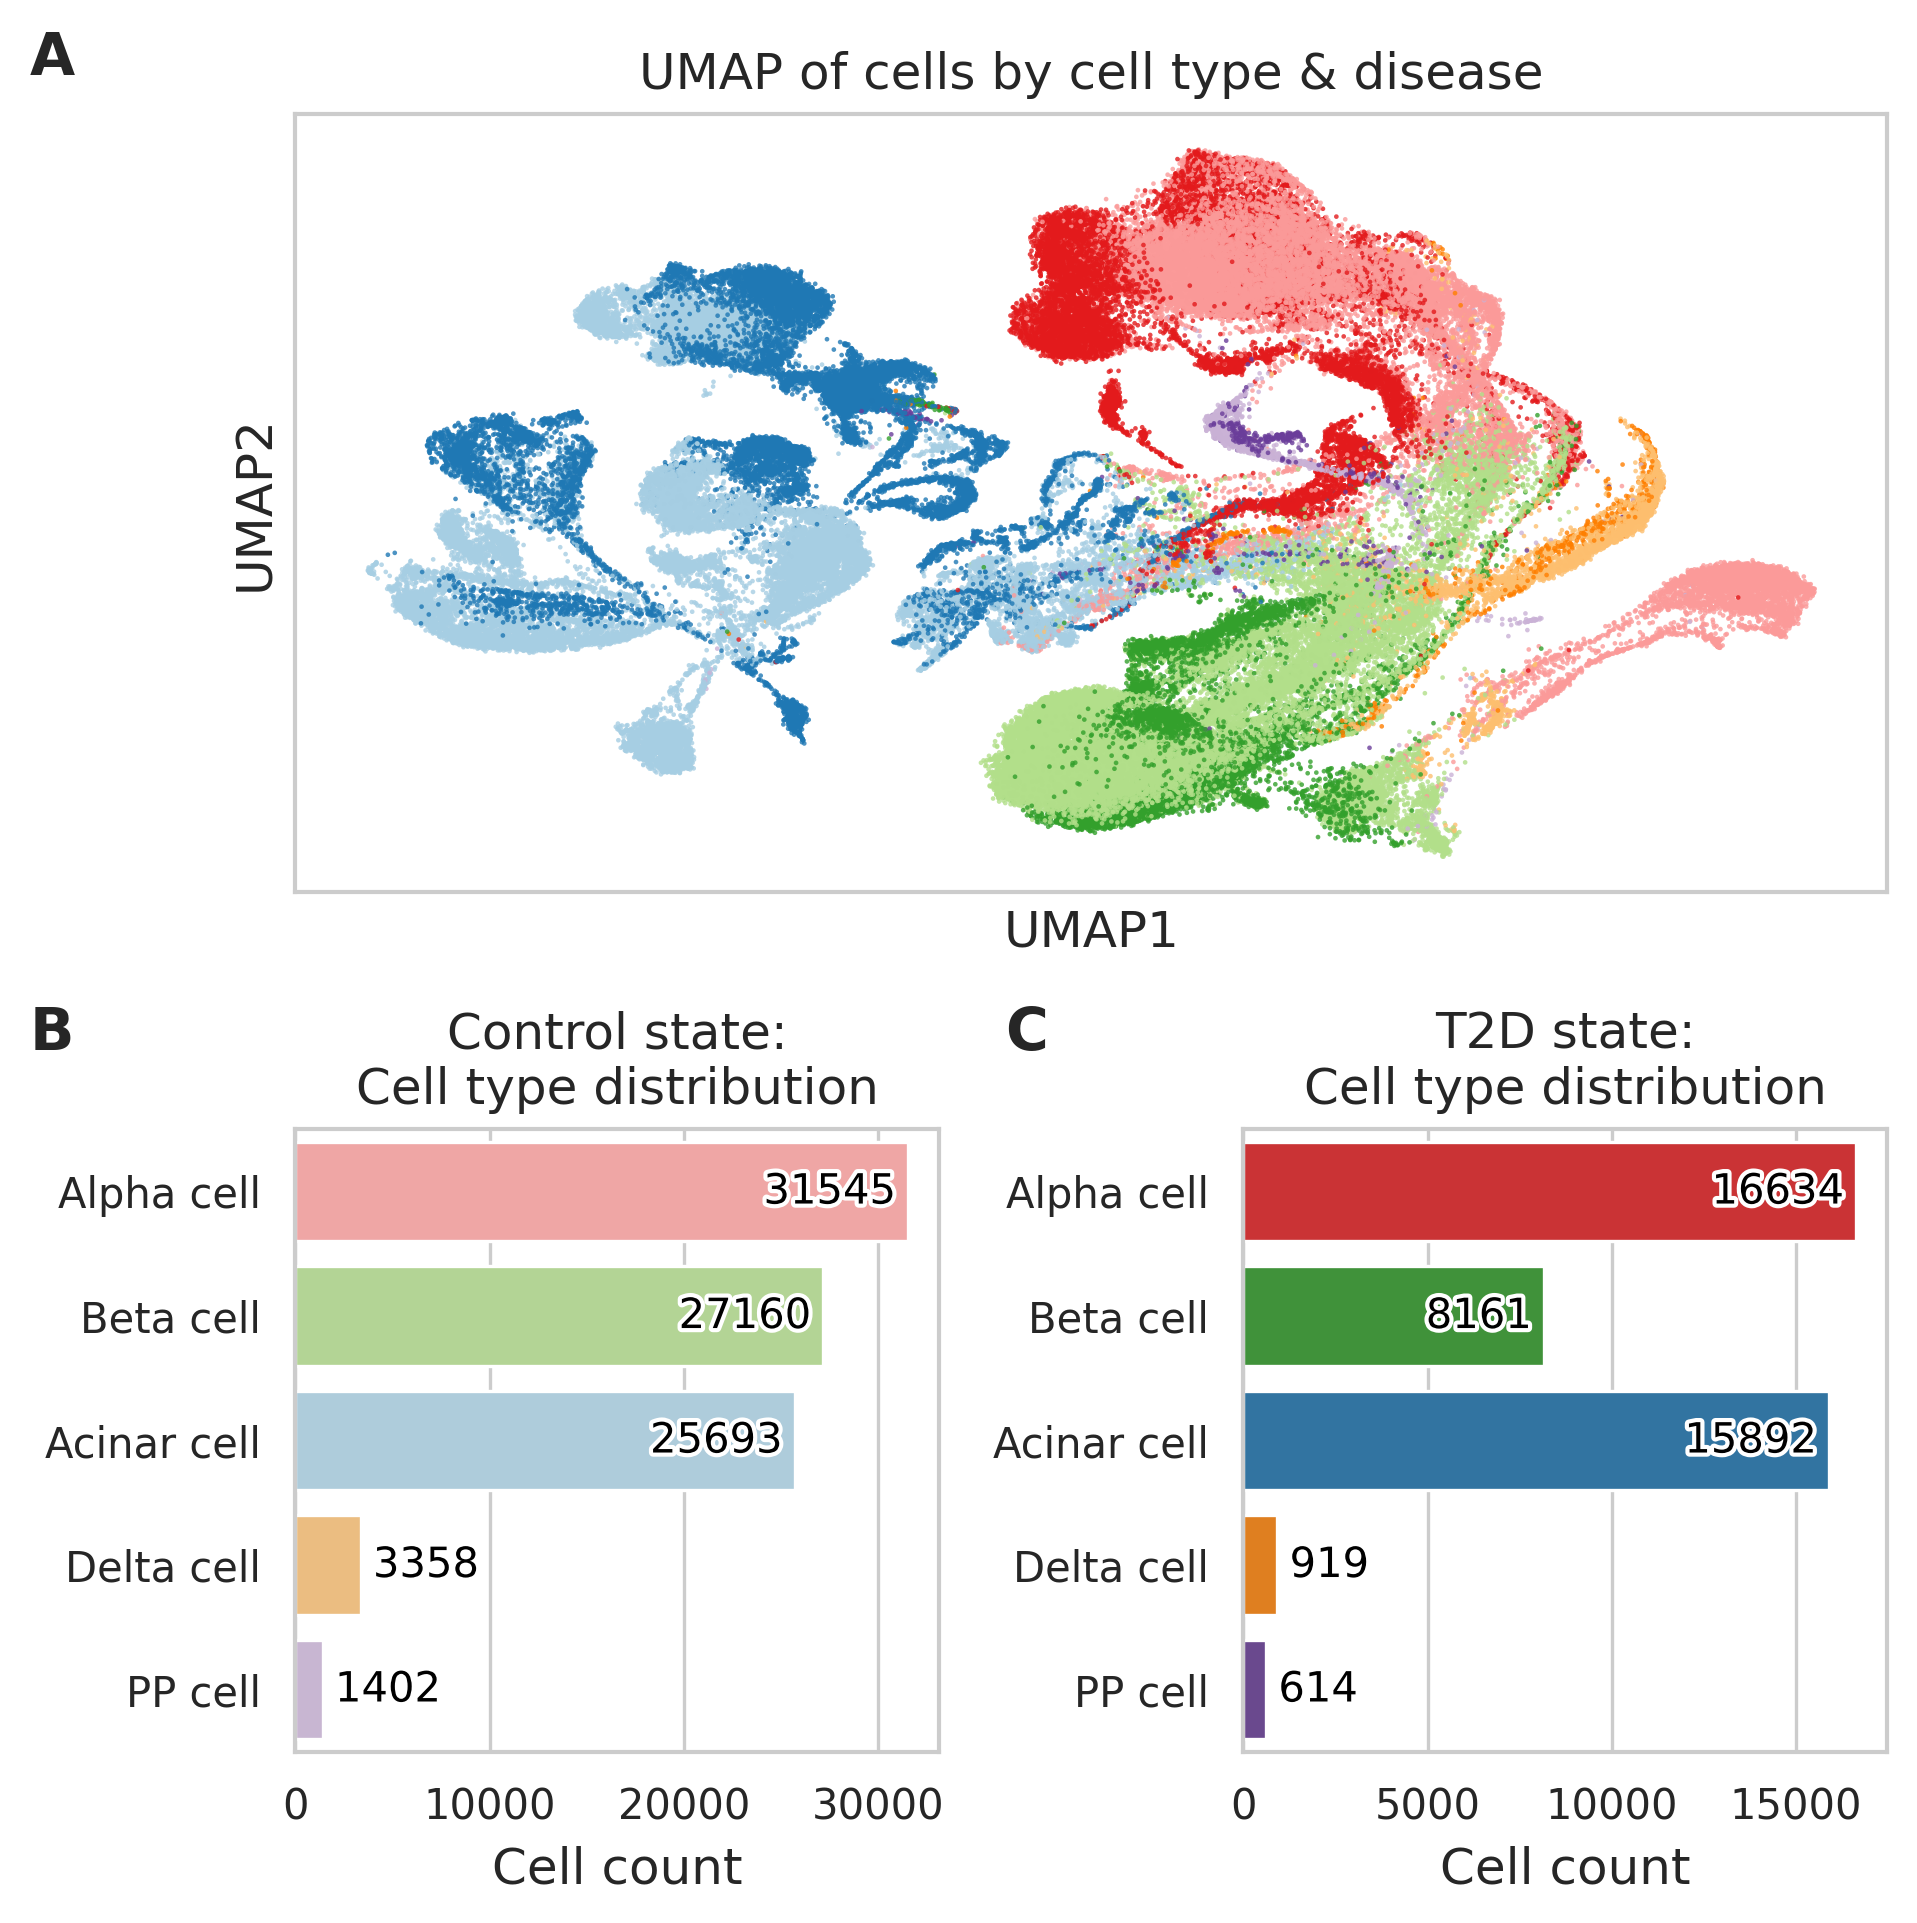

In [42]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from matplotlib import patheffects as pe

def plot_cell_umap_and_distributions(adata, output_file="hpap.pdf"):
    """
    3‐panel figure:
      A) UMAP colored by cell_type×disease_state (10 colors; no legend)
      B) Control barplot, C) T2D barplot,
    with counts placed inside bars ≥20% of max, else outside, all in black
    with white outline.
    """
    # 1) Publication styling
    sns.set_context("paper", font_scale=1.2)
    rcParams.update({
        "font.size":       12,
        "axes.titlesize":  12,
        "axes.labelsize":  12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi":     300,
    })
    
    # 2) Cell‐types, pretty names, 10‐color palette
    cell_types = ["alpha_cell","beta_cell","acinar_cell","delta_cell","PP_cell"]
    pretty = {
        "alpha_cell":"Alpha cell",
        "beta_cell": "Beta cell",
        "acinar_cell":"Acinar cell",
        "delta_cell":"Delta cell",
        "PP_cell":   "PP cell"
    }
    combos = [f"{ct}_Control" for ct in cell_types] + [f"{ct}_T2D" for ct in cell_types]
    combo_palette = dict(zip(combos, sns.color_palette("tab10", n_colors=len(combos))))

    
    # 2’) Define a colorblind‐safe paired palette
    base_colors = {
        "alpha_cell": "#fb9a99",
        "beta_cell":  "#b2df8a",
        "acinar_cell":"#a6cee3",
        "delta_cell": "#fdbf6f",
        "PP_cell":    "#cab2d6",
    }
    dark_colors = {
        "alpha_cell": "#e31a1c",
        "beta_cell":  "#33a02c",
        "acinar_cell":"#1f78b4",
        "delta_cell": "#ff7f00",
        "PP_cell":    "#6a3d9a",
    }
    
    # build the 10‐category palette
    combo_palette = {}
    for ct in cell_types:
        combo_palette[f"{ct}_Control"] = base_colors[ct]
        combo_palette[f"{ct}_T2D"]     = dark_colors[ct]
    
    # 3) Figure & gridspec
    fig = plt.figure(figsize=(6.5, 6.5))
    gs  = fig.add_gridspec(2, 2, height_ratios=[1, 0.8])
    
    # — Panel A: UMAP —
    ax0 = fig.add_subplot(gs[0, :])
    sc.pl.umap(
        adata,
        color="cell_disease",
        palette=combo_palette,
        ax=ax0,
        show=False,
        s=5, alpha=0.8
    )
    ax0.set_title("UMAP of cells by cell type & disease")
    if ax0.get_legend(): 
        ax0.legend_.remove()
    
    # — Panels B & C: barplots —
    for col, state in enumerate(["Control", "T2D"]):
        ax = fig.add_subplot(gs[1, col])
        sub    = adata.obs.query("disease_state == @state")
        counts = sub["cell_type"].value_counts().reindex(cell_types)
        
        # draw bars
        colors = [combo_palette[f"{ct}_{state}"] for ct in counts.index]
        sns.barplot(
            x=counts.values,
            y=[pretty[ct] for ct in counts.index],
            palette=colors,
            ax=ax
        )
        
        # two‐line title
        ax.set_title(f"{state} state:\nCell type distribution", loc="center")
        ax.set_xlabel("Cell count")
        ax.set_ylabel("")
        
        # 5% white margin on the right
        maxc = counts.max()
        ax.set_xlim(0, maxc * 1.05)
        
        # annotate: inside if ≥20% of max, else outside
        threshold = maxc * 0.20
        offset    = maxc * 0.02
        
        for x, y in zip(counts.values, range(len(counts))):
            if x >= threshold:
                # inside
                xpos, ha = x - offset, "right"
            else:
                # outside
                xpos, ha = x + offset, "left"
            
            txt = ax.text(
                xpos, y, str(x),
                va="center", ha=ha,
                color="black", fontsize=10,
                clip_on=False
            )
            # white outline
            txt.set_path_effects([
                pe.Stroke(linewidth=2, foreground="white"),
                pe.Normal()
            ])
    
    # 4) Adjust spacing
    fig.subplots_adjust(
        left=0.08, right=0.98,
        top=0.94,  bottom=0.08,
        wspace=0.4, hspace=0.3
    )
    
    # 5) Panel letters
    fig.text(0.02, 0.96, "A", fontsize=14, fontweight="bold")
    fig.text(0.02, 0.46, "B", fontsize=14, fontweight="bold")
    fig.text(0.52, 0.46, "C", fontsize=14, fontweight="bold")
    
    # 6) Save
    plt.tight_layout()
    fig.savefig(output_file)

    plt.show()
    plt.close(fig)


plot_cell_umap_and_distributions(adata, output_file=f'{main_path}{single_cell_data}/hpapnb-batch_corrected.png')
#fig.savefig()

In [13]:

min_layer_size_star=int(adata.shape[1]*1/4)
max_layer_size_star=int(adata.shape[1]*2/4)


min_layer_size_oracle=int(adata.shape[1]*1/4)
max_layer_size_oracle=int(adata.shape[1]*2/4)

min_layer_size_prop=int(adata.shape[1]*1/4)
max_layer_size_prop=int(adata.shape[1]*2/4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
###########################################################################################
#### Stargan
###########################################################################################
###########################################################################################         
study = optuna.create_study(storage="sqlite:///"+outdir+"/"+single_cell_data.replace(" ","_")+"_stargan_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=single_cell_data.replace(" ", "_")+"_stargan_main.db",
                            load_if_exists=True)


start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_stargan(trial, adata,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_star,max_layer_size=max_layer_size_star,burn_in=burn_in, bsize=bsize,zi=zi), n_trials=hyperparam_trials-len(study.get_trials()))

# Get the best hyperparameters
best_params = study.best_params

stargan_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes_generator': [
        best_params["gen_layer0"],
        best_params["gen_layer1"],
        best_params["gen_layer2"]
    ],
    'layer_nodes_discriminator': [
        best_params["disc_layer0"],
        best_params["disc_layer1"],
        best_params["disc_layer2"]
    ],
    'critics': 3,#best_params["critics"],
#"lambda_adv":best_params["lambda_adv"],
#"lambda_cls":best_params["lambda_cls"],
#"lambda_rec":best_params["lambda_rec"],
#"lambda_iden":best_params["lambda_iden"],
    "dropout_rate":best_params["dropout_rate"]
}
'''
stargan_hyperparam = {
    'batch_size': 512,
    'learning_rate': 0.001,
    'layer_nodes_generator': [
        250,
        100,
        250
    ],
    'layer_nodes_discriminator': [
        250,
        125,
        250
    ],
    'critics': 3,
"lambda_adv":1,
"lambda_cls":1,
"lambda_rec":10,
"lambda_iden":1,
"lambda_sink":1,
    "dropout_rate":0.1
}


'''
###########################################################################################
###########################################################################################
#### Oracle
###########################################################################################
###########################################################################################


study = optuna.create_study(storage="sqlite:///"+outdir+"/"+single_cell_data.replace(" ","_")+"_oracle_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=single_cell_data.replace(" ", "_")+"_oracle_main.db",
                            load_if_exists=True)

start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_oracle(trial, adata,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_oracle,max_layer_size=max_layer_size_oracle,burn_in=burn_in, bsize=bsize), n_trials=hyperparam_trials-len(study.get_trials()))
print(time.time()-start_time)
# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)
oracle_hyperparam = {'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes': [
        best_params["disc_layer0"],
        best_params["disc_layer1"],
        best_params["disc_layer2"]
    ],
    'dropout_rate_d': best_params['disc_dropout_rate']
}
'''

oracle_hyperparam = {'batch_size': 512,
    'learning_rate': 0.001,
    'layer_nodes': [
        200,
        150,
        100
    ],
    'dropout_rate_d': 0.1
}
'''       
###########################################################################################
###########################################################################################
#### Propagator
###########################################################################################
###########################################################################################

study = optuna.create_study(storage="sqlite:///"+outdir+"/"+single_cell_data.replace(" ","_")+"_propagator_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=single_cell_data.replace(" ", "_")+"_propagator_main.db",
                            load_if_exists=True)

start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_propagator(trial, adata,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_prop,max_layer_size=max_layer_size_prop,burn_in=burn_in, bsize=bsize,zi=zi), n_trials=hyperparam_trials-len(study.get_trials()))
print(time.time()-start_time)
# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

propagator_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes_generator': [
        best_params["gen_layer0"],
        best_params["gen_layer1"],
        best_params["gen_layer2"]
    ],
    'dropout_rate_g': best_params['gen_dropout_rate'],
    'latent_dim':best_params['latent'],
    'beta':float(best_params['beta'])
    
}
shared_filter = None
filter_criteria_start = ["start"]
filter_criteria_goal  = ["goal"]



loss_weights=[1,1,10,10]
train_adata,val_adata=  split_and_maxabs_scale_adata(adata,validation_ratio)
#################################################
###Refit models with new zero-inflation
#################################################
stargan = gosip.StarGAN(input_dim=adata.shape[1],
                 num_domains=[adata.one_hot_labels.shape[1]],
                 device = device,
                 learning_rate = stargan_hyperparam['learning_rate'],
                 layer_g = stargan_hyperparam['layer_nodes_generator'],
                 layer_d = stargan_hyperparam['layer_nodes_discriminator'],
                 critics = stargan_hyperparam['critics'],
                  lambda_adv=loss_weights[0],
                  lambda_cls=loss_weights[1],
                  lambda_rec=loss_weights[2],
                  #lambda_iden=loss_weights[3],
                  #lambda_sink=loss_weights[4],
                 dropout_rate=stargan_hyperparam["dropout_rate"],
                       zi=zi)


train_dataloader = gosip.prepare_data(train_adata,num_categories,batch_size=stargan_hyperparam["batch_size"])
val_dataloader = gosip.prepare_data(val_adata,num_categories,batch_size=stargan_hyperparam["batch_size"])
stargan.train( dataloader=train_dataloader,val_loader=val_dataloader, num_epochs=num_epochs,patience=patience,burn_in=burn_in,verbose=True)
stargan.G.eval()
stargan.D.eval()
torch.cuda.empty_cache()

oracle = gosip.Oracle(input_dim=adata.shape[1],
         num_domains=num_categories,
         device = device,
         learning_rate = oracle_hyperparam['learning_rate'],
         layer_d = oracle_hyperparam['layer_nodes'],
         drpt_d = oracle_hyperparam['dropout_rate_d'])
train_dataloader = gosip.prepare_data(train_adata,num_categories,batch_size=oracle_hyperparam["batch_size"])
val_dataloader = gosip.prepare_data(val_adata,num_categories,batch_size=oracle_hyperparam["batch_size"])
oracle.train(dataloader=train_dataloader, val_loader=val_dataloader, num_epochs=num_epochs,patience=patience,burn_in=burn_in,verbose=True,optuna_run=False)
oracle.D.eval()
torch.cuda.empty_cache()
train_dataloader = gosip.prepare_data(train_adata,num_categories,batch_size=propagator_hyperparam["batch_size"])
val_dataloader = gosip.prepare_data(val_adata,num_categories,batch_size=propagator_hyperparam["batch_size"])
propagator = gosip.Propagator(input_dim=train_adata.shape[1],
                 num_domains=num_categories,
                 device = device,
                 learning_rate = propagator_hyperparam['learning_rate'],
                 layer_g = propagator_hyperparam['layer_nodes_generator'],
                 drpt_g = propagator_hyperparam['dropout_rate_g'],
                 latent_dim=propagator_hyperparam['latent_dim'],zi=zi)
loss_fn = gosip.BtcvaeLoss(n_data=train_adata.shape[0], alpha=1.0, beta=propagator_hyperparam['beta'], gamma=1.0,zi=zi)
propagator.train(dataloader=train_dataloader, val_loader=val_dataloader,
                 num_epochs=num_epochs,patience=patience,burn_in=burn_in, verbose=True,optuna_run=False,
                 loss_fn=loss_fn)

-5.773786941459276

In [14]:
import json
with open(f'{main_path}{single_cell_data}/stargan_hyperparam_selected.json', 'w') as f:
    json.dump(stargan_hyperparam, f)

with open(f'{main_path}{single_cell_data}/propagator_hyperparam_selected.json', 'w') as f:
    json.dump(propagator_hyperparam, f)

with open(f'{main_path}{single_cell_data}/oracle_hyperparam_selected.json', 'w') as f:
    json.dump(oracle_hyperparam, f)
propagator_hyperparameter_ranges = optuna.create_study(storage="sqlite:///"+outdir+"/"+single_cell_data.replace(" ","_")+"_propagator_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=single_cell_data.replace(" ", "_")+"_propagator_"+"main.db",
                            load_if_exists=True).trials[0].distributions

oracle_hyperparameter_ranges = optuna.create_study(storage="sqlite:///"+outdir+"/"+single_cell_data.replace(" ","_")+"_oracle_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=single_cell_data.replace(" ", "_")+"_oracle_"+"main.db",
                            load_if_exists=True).trials[0].distributions
stargan_hyperparameter_ranges = optuna.create_study(storage="sqlite:///"+outdir+"/"+single_cell_data.replace(" ","_")+"_stargan_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=single_cell_data.replace(" ", "_")+"_stargan"+"_main.db",
                            load_if_exists=True).trials[0].distributions




[I 2025-05-17 13:00:54,185] Using an existing study with name 'hpapnb3k_propagator_main.db' instead of creating a new one.
[I 2025-05-17 13:00:54,594] Using an existing study with name 'hpapnb3k_oracle_main.db' instead of creating a new one.
[I 2025-05-17 13:00:54,721] Using an existing study with name 'hpapnb3k_stargan_main.db' instead of creating a new one.


In [15]:

def convert_distributions_to_string(input_dict):
    # Create a new dictionary to store the updated values
    output_dict = {}
    
    for key, value in input_dict.items():
        output_dict[key] = str(value)  # for other types, store the original value

    return output_dict




import json
with open(f'{main_path}{single_cell_data}/stargan_hyperparam_ranges.json', 'w') as f:
    json.dump(convert_distributions_to_string(stargan_hyperparameter_ranges), f)

with open(f'{main_path}{single_cell_data}/propagator_hyperparam_ranges.json', 'w') as f:
    json.dump(convert_distributions_to_string(propagator_hyperparameter_ranges), f)

with open(f'{main_path}{single_cell_data}/oracle_hyperparam_ranges.json', 'w') as f:
    json.dump(convert_distributions_to_string(oracle_hyperparameter_ranges), f)

In [16]:
adata.obs['disease_state']=="Control"
adata.obs['cell disease']=adata.obs['cell_disease'].str.replace("_"," ")

In [17]:
len(adata.obs['donor_id'].value_counts().index)


48

/tmp/ipykernel_271140/3462046081.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index.str.replace("_", " "), ax=ax2, palette="Blues_r")
/tmp/ipykernel_271140/3462046081.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index.str.replace("_", " "), ax=ax3, palette="Reds_r")


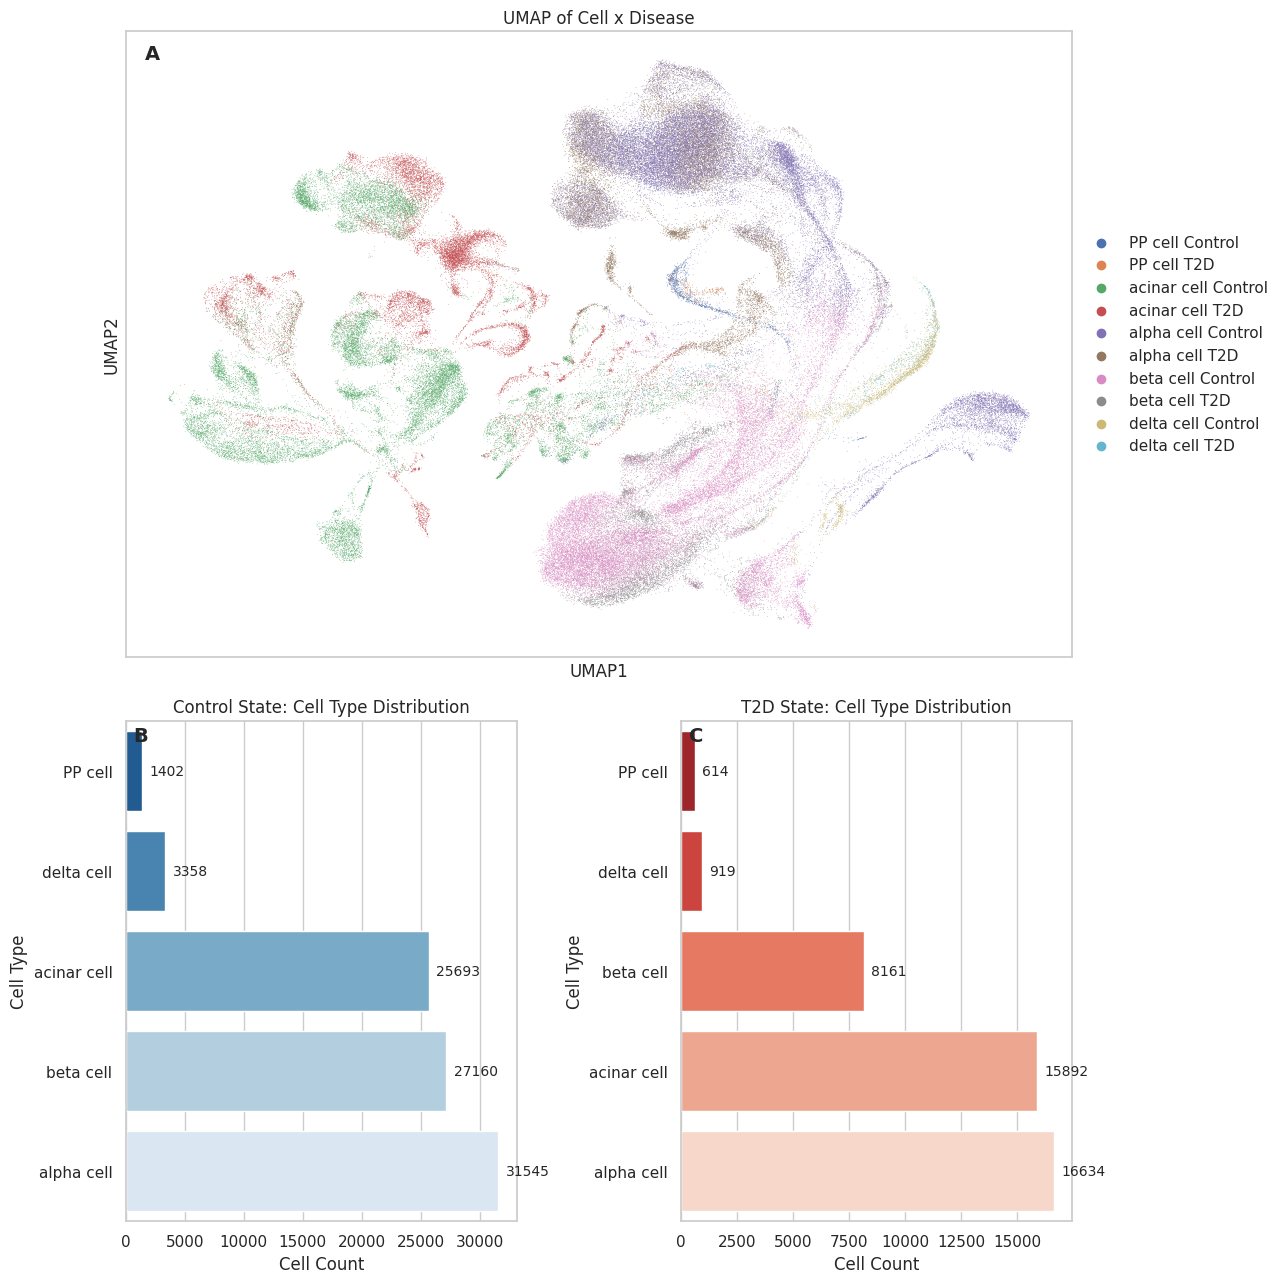

In [19]:
import json
with open(f'{main_path}{single_cell_data}/stargan_hyperparam.json', 'w') as f:
    json.dump(stargan_hyperparam, f)

with open(f'{main_path}{single_cell_data}/propagator_hyperparam.json', 'w') as f:
    json.dump(propagator_hyperparam, f)

with open(f'{main_path}{single_cell_data}/oracle_hyperparam.json', 'w') as f:
    json.dump(oracle_hyperparam, f)

/home/jislam/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


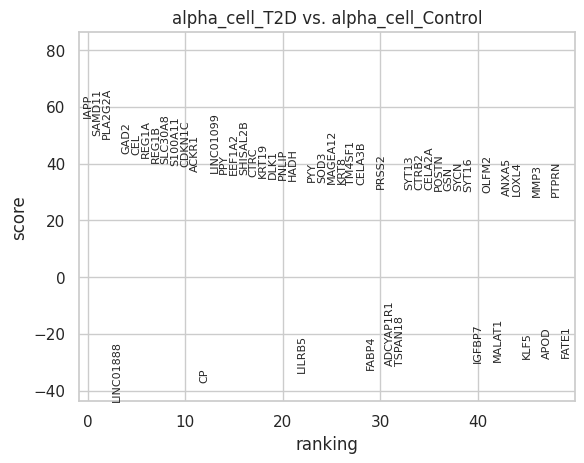

In [20]:

sc.tl.rank_genes_groups(adata, groupby='cell_disease', groups=['alpha_cell_T2D'], reference='alpha_cell_Control', method='t-test', use_raw=False,rankby_abs=True,key_added="cause_alpha_T2D")
sc.pl.rank_genes_groups(adata, n_genes=50,key="cause_alpha_T2D")

In [21]:

sc.tl.rank_genes_groups(adata, groupby='cell_disease', groups=group_a, reference=group_b[0], method='t-test', use_raw=False,rankby_abs=True,key_added="cure_T2D")
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save=outdir+"basic_test.png")
sc.tl.rank_genes_groups(adata, groupby='cell_disease', groups=group_b, reference=group_a[0], method='t-test', use_raw=False,rankby_abs=True,key_added="cause_T2D")
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save=outdir+"basic_test.png")
cure_dge = extract_rank_genes_groups(adata, key='cure_T2D', n_genes=None).drop(columns=['logfoldchange','pval','pval_adj','group'])
cause_dge = extract_rank_genes_groups(adata, key='cause_T2D', n_genes=None).drop(columns=['logfoldchange','pval','pval_adj','group'])


/home/jislam/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jislam/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [22]:
processed_adata = anndata.concat(
    [train_adata, val_adata],
    join='inner',            # only keep genes present in both
    label='split',           # name of the new obs column
    keys=['train', 'val'],   # values in combined_adata.obs['split']
    fill_value=0
)

# 2. Stitch the one_hot_labels together
combined_labels = pd.concat(
    [train_adata.one_hot_labels, val_adata.one_hot_labels],
    axis=0
)
# 3. Re‐order them to match the new obs order, then attach back
combined_labels = combined_labels.reindex(processed_adata.obs_names)
processed_adata.one_hot_labels = combined_labels.copy()

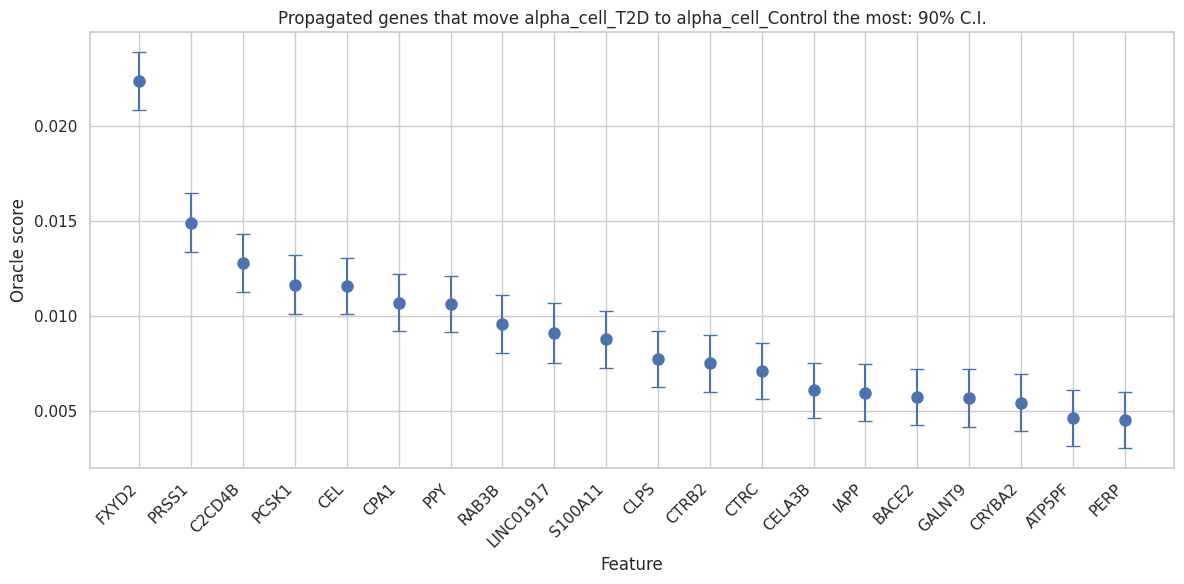

5041

In [23]:


start_time=time.time()
shared_filter = None
filter_criteria_start = ["alpha_cell_Control"] #["cell_disease=beta cell_Tumor"] #
filter_criteria_goal =["alpha_cell_T2D"] # ["cell_disease=beta cell_Normal"]# 
perturbation_metrics,accuracy,result_path=gosip.full_report(adata=processed_adata,
                                 stargan=stargan,
                                 oracle=oracle,
                                propagator=propagator,
                                shared_filter=shared_filter,
                                filter_criteria_start=filter_criteria_start,
                                filter_criteria_goal=filter_criteria_goal,
                                device=device,num_categories=num_categories,category_labels=category_labels,
                                main_path=main_path,outdir=outdir,top_n=20,percentile=0,
                                umap=False,oracle_performance=True,alpha=0.5,k=k)


torch.cuda.empty_cache()
gc.collect()

perturbation_metrics.to_csv(result_path+"summary_statistics.csv")
perturbation_metrics_start_to_goal=perturbation_metrics.copy()
perturbation_metrics,accuracy,result_path=gosip.full_report(adata=processed_adata,
                                 stargan=stargan,
                                 oracle=oracle,
                                          propagator=propagator,
                                          shared_filter=shared_filter,
                                 filter_criteria_start=filter_criteria_goal,
                                 filter_criteria_goal=filter_criteria_start,
                                device=device,num_categories=num_categories,category_labels=category_labels,
                                 main_path=main_path,outdir=outdir,top_n=20,percentile=0,
                                 umap=False,oracle_performance=True,alpha=0.5,k=k)
perturbation_metrics.to_csv(result_path+"summary_statistics.csv")
perturbation_metrics_goal_to_start=perturbation_metrics.copy()

torch.cuda.empty_cache()
gc.collect()

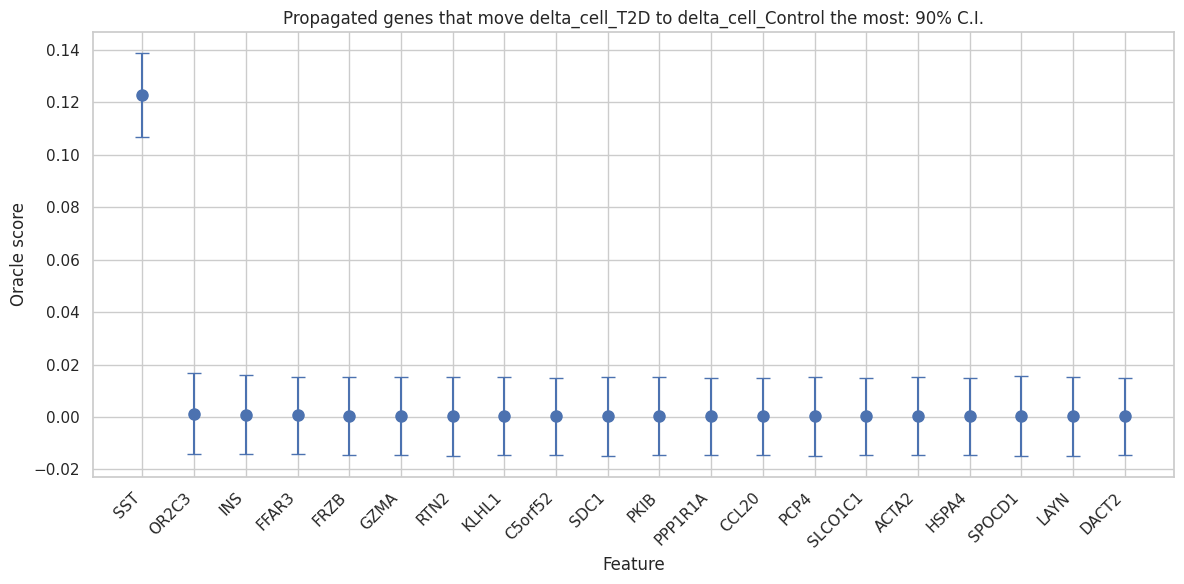

5640

In [24]:

shared_filter = None
filter_criteria_start = ["delta_cell_Control"] #["cell_disease=beta cell_Tumor"] #
filter_criteria_goal =["delta_cell_T2D"] # ["cell_disease=beta cell_Normal"]# 
perturbation_metrics,accuracy,result_path=gosip.full_report(adata=processed_adata,
                                stargan=stargan,
                                oracle=oracle,
                                propagator=propagator,
                                shared_filter=shared_filter,
                                filter_criteria_start=filter_criteria_start,
                                filter_criteria_goal=filter_criteria_goal,
                                device=device,num_categories=num_categories,category_labels=category_labels,
                                main_path=main_path,outdir=outdir,top_n=20,percentile=0,
                                umap=False,oracle_performance=True,alpha=0.5,k=k)


torch.cuda.empty_cache()
gc.collect()

perturbation_metrics.to_csv(result_path+"summary_statistics.csv")
perturbation_metrics_start_to_goal=perturbation_metrics.copy()
perturbation_metrics,accuracy,result_path=gosip.full_report(adata=processed_adata,
                                 stargan=stargan,
                                 oracle=oracle,
                                          propagator=propagator,
                                          shared_filter=shared_filter,
                                 filter_criteria_start=filter_criteria_goal,
                                 filter_criteria_goal=filter_criteria_start,
                                device=device,num_categories=num_categories,category_labels=category_labels,
                                 main_path=main_path,outdir=outdir,top_n=20,percentile=0,
                                 umap=False,oracle_performance=True,alpha=0.5,k=k)
perturbation_metrics.to_csv(result_path+"summary_statistics.csv")
perturbation_metrics_goal_to_start=perturbation_metrics.copy()

torch.cuda.empty_cache()
gc.collect()

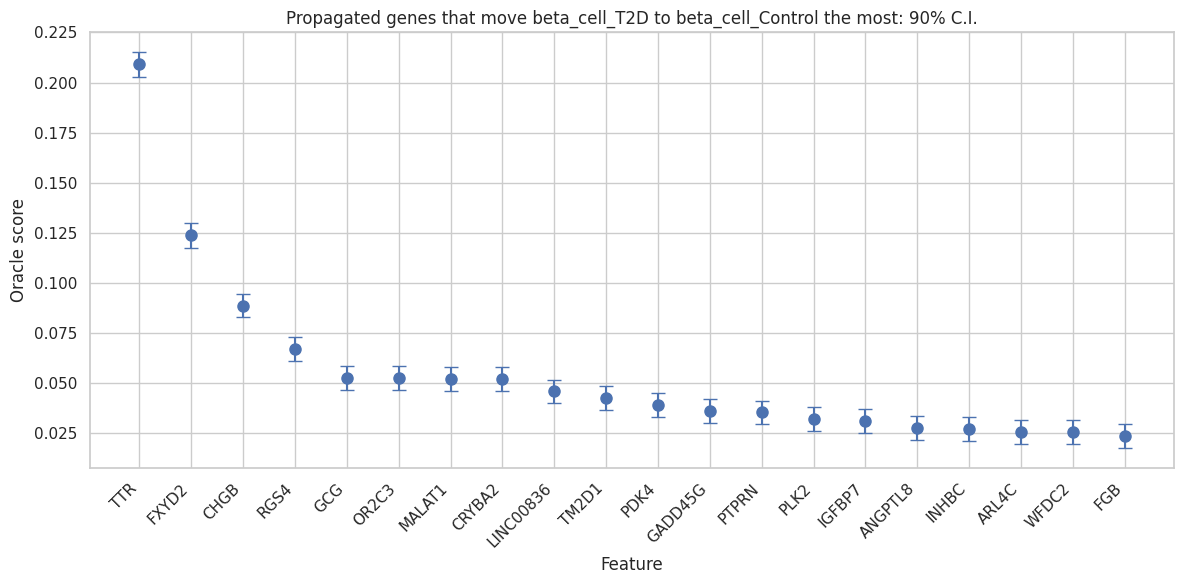

131809.180


In [25]:


shared_filter = None
filter_criteria_start = ["beta_cell_Control"] #["cell_disease=beta cell_Tumor"] #
filter_criteria_goal =["beta_cell_T2D"] # ["cell_disease=beta cell_Normal"]# 
perturbation_metrics,accuracy,result_path=gosip.full_report(adata=processed_adata,
                                 stargan=stargan,
                                 oracle=oracle,
                                propagator=propagator,
                                shared_filter=shared_filter,
                                filter_criteria_start=filter_criteria_start,
                                filter_criteria_goal=filter_criteria_goal,
                                device=device,num_categories=num_categories,category_labels=category_labels,
                                main_path=main_path,outdir=outdir,top_n=20,percentile=0,
                                umap=False,oracle_performance=True,alpha=0.5,k=k)


torch.cuda.empty_cache()
gc.collect()

perturbation_metrics.to_csv(result_path+"summary_statistics.csv")
perturbation_metrics_start_to_goal=perturbation_metrics.copy()
perturbation_metrics,accuracy,result_path=gosip.full_report(adata=processed_adata,
                                 stargan=stargan,
                                 oracle=oracle,
                                          propagator=propagator,
                                          shared_filter=shared_filter,
                                 filter_criteria_start=filter_criteria_goal,
                                 filter_criteria_goal=filter_criteria_start,
                                device=device,num_categories=num_categories,category_labels=category_labels,
                                 main_path=main_path,outdir=outdir,top_n=20,percentile=0,
                                 umap=False,oracle_performance=True,alpha=0.5,k=k)
perturbation_metrics.to_csv(result_path+"summary_statistics.csv")
perturbation_metrics_goal_to_start=perturbation_metrics.copy()

torch.cuda.empty_cache()
gc.collect()
end_time=time.time()
print(f'{end_time-start_time:.3f}')

In [26]:
sc.tl.rank_genes_groups(adata, groupby='cell_disease', groups=group_a, reference=group_b[0], method='t-test', use_raw=False,rankby_abs=True,key_added="cure_T2D")
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save=outdir+"basic_test.png")
sc.tl.rank_genes_groups(adata, groupby='cell_disease', groups=group_b, reference=group_a[0], method='t-test', use_raw=False,rankby_abs=True,key_added="cause_T2D")
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save=outdir+"basic_test.png")
cure_dge = extract_rank_genes_groups(adata, key='cure_T2D', n_genes=None).drop(columns=['logfoldchange','pval','pval_adj','group'])
cause_dge = extract_rank_genes_groups(adata, key='cause_T2D', n_genes=None).drop(columns=['logfoldchange','pval','pval_adj','group'])
torch.cuda.empty_cache()
gc.collect()

/home/jislam/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jislam/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


28

In [27]:
perturbation_metrics#.sort_values('oracle_score')

in_degree_pagerank_positive  out_degree_pagerank_positive  \
gene_name                                                              
A1BG                          1.074781                      1.012218   
A2M                           1.028217                      1.023506   
A4GALT                        1.017007                      1.003250   
AADAC                         1.008681                      1.005352   
AASDH                         1.054256                      1.010449   
...                                ...                           ...   
ZNF879                        1.030901                      1.032462   
ZNRF3-IT1                     1.062670                      1.019633   
ZSCAN10                       1.085000                      1.048432   
ZSCAN29                       6.297749                      6.903402   
ZWINT                         6.147557                      6.706936   

           oracle_score  suggested_perturbation      label  \
gene_name                                                    
A1BG           0.001831               -0.015287       A1BG   
A2M            0.000387               -0.000839        A2M   
A4GALT         0.000639                0.003403     A4GALT   
AADAC          0.001358               -0.010329      AADAC   
AASDH          0.001075               -0.012406      AASDH   
...                 ...                     ...        ...   
ZNF879         0.000417                0.012724     ZNF879   
ZNRF3-IT1      0.013290               -0.017455  ZNRF3-IT1   
ZSCAN10        0.000857                0.006370    ZSCAN10   
ZSCAN29        0.000306                0.000780    ZSCAN29   
ZWINT          0.000102                0.002084      ZWINT   

           in_degree_pagerank_positive_se  out_degree_pagerank_positive_se  \
gene_name                                                                    
A1BG                             0.060210                         0.008535   
A2M                              0.023194                         0.011197   
A4GALT                           0.010369                         0.002403   
AADAC                            0.008553                         0.003892   
AASDH                            0.027614                         0.005631   
...                                   ...                              ...   
ZNF879                           0.023879                         0.020311   
ZNRF3-IT1                        0.040930                         0.010289   
ZSCAN10                          0.054701                         0.018815   
ZSCAN29                          0.107667                         0.101641   
ZWINT                            0.142507                         0.063478   

           oracle_score_se  suggested_perturbation_se  \
gene_name                                               
A1BG              0.000244                   0.000076   
A2M               0.000194                   0.000008   
A4GALT            0.000200                   0.000004   
AADAC             0.000224                   0.000007   
AASDH             0.000209                   0.000051   
...                    ...                        ...   
ZNF879            0.000171                   0.000023   
ZNRF3-IT1         0.000404                   0.000007   
ZSCAN10           0.000209                   0.000005   
ZSCAN29           0.000189                   0.000034   
ZWINT             0.000183                   0.000010   

           oracle_score_pval_acat_fdr    k  
gene_name                                   
A1BG                         0.277621  100  
A2M                          0.990682  100  
A4GALT                       0.477524  100  
AADAC                        0.442681  100  
AASDH                        0.948034  100  
...                               ...  ...  
ZNF879                       0.868662  100  
ZNRF3-IT1                    0.000014  100  
ZSCAN10                      0.657821  100  
ZSCAN29        

In [28]:
mart_main=pd.read_csv('/home/jislam/Documents/gits/rnaseq_bulk/pdac_bulk/mart_export.txt',sep="\t")
mart_main=mart_main.loc[~mart_main['NCBI gene (formerly Entrezgene) ID'].isna(),:]
mart_main=mart_main.drop(columns=['EntrezGene transcript name ID','Gene stable ID'],axis=1)
mart_main=mart_main[~mart_main.duplicated()]
mart_main.columns=['gene_name','ncbi_id']
mart_main

gene_name      ncbi_id
5         MT-ND1       4535.0
9         MT-ND2       4536.0
15        MT-CO1       4512.0
16        MT-TS1  113219467.0
18        MT-CO2       4513.0
...          ...          ...
76738  SCARNA21B  107397391.0
76740      AGMAT      79814.0
76745       DDI2      84301.0
76746     RSC1A1       6248.0
76748    PLEKHM2      23207.0

[30348 rows x 2 columns]

In [29]:
import pandas as pd
from sklearn.decomposition import PCA
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_umap(dataframe, key_column, highlight_keys=None, figsize=(10, 8), default_color="gray"):
    """
    Plot UMAP-transformed data, highlighting specified keys with colors.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing UMAP components and the key column.
    - key_column (str): Column name used for grouping and coloring points.
    - highlight_keys (list): List of keys to highlight in distinct colors. Others will be in a default color.
    - figsize (tuple): Figure size for the plot (default: (10, 8)).
    - default_color (str): Color for keys not in the highlight list (default: "gray").
    
    Returns:
    - None: Displays the scatter plot.
    """
    # Validate highlight_keys
    highlight_keys = set(highlight_keys) if highlight_keys else set()

    # Separate highlighted and non-highlighted data
    highlighted_data = dataframe[dataframe[key_column].isin(highlight_keys)]
    non_highlighted_data = dataframe[~dataframe[key_column].isin(highlight_keys)]

    # Start plotting
    plt.figure(figsize=figsize)

    # Plot non-highlighted data
    if not non_highlighted_data.empty:
        plt.scatter(
            non_highlighted_data["UMAP1"],
            non_highlighted_data["UMAP2"],
            color=default_color,
            alpha=0.6,
            s=1,
            label="Other",
        )

    # Plot highlighted data
    if not highlighted_data.empty:
        sns.scatterplot(
            data=highlighted_data,
            x="UMAP1",
            y="UMAP2",
            hue=key_column,
            palette="tab10",  # Use a color palette for highlighted keys
            s=5,
            alpha=0.9,
        )

    # Add labels and legend
    plt.title("UMAP Projection", fontsize=14)
    plt.xlabel("UMAP1", fontsize=12)
    plt.ylabel("UMAP2", fontsize=12)
    plt.legend(title=key_column, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
    plt.tight_layout()
    plt.show()
    return fig
def pca_umap_transform(dataframe, key_column, n_pca_components=40, n_umap_components=2, n_neighbors=5, min_dist=0.3, random_state=None):
    """
    Perform PCA followed by UMAP on a DataFrame, excluding a specified key column.

    Parameters:
    - dataframe (pd.DataFrame): Input DataFrame.
    - key_column (str): Column name to exclude from PCA and UMAP transformations.
    - n_pca_components (int): Number of components for PCA.
    - n_umap_components (int): Number of dimensions for UMAP reduction.
    - n_neighbors (int): Number of neighbors for UMAP.
    - min_dist (float): Minimum distance between points in UMAP.
    - random_state (int): Seed for reproducibility.

    Returns:
    - pd.DataFrame: Transformed DataFrame with UMAP components and the key column.
    """
    # Separate the key column
    keys = dataframe[key_column]
    numerical_data = dataframe.drop(columns=[key_column])
    '''
    # Apply PCA
    pca = PCA(n_components=n_pca_components)
    pca_result = pca.fit_transform(numerical_data)
    '''
    # Apply UMAP
    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_umap_components,
        random_state=random_state,
    )
    umap_result = umap_model.fit_transform(numerical_data)

    # Create a new DataFrame with UMAP results
    result_df = pd.DataFrame(umap_result, columns=[f"UMAP{i+1}" for i in range(n_umap_components)])
    result_df[key_column] = keys.reset_index(drop=True)

    return result_df


def generate_example_cells(adata,start_tensor, transition_label_tensor, stargan, propagator,cells_to_generate,top_genes,latent):
    if latent:
        pg=propagator.G.encoder
    else:
        pg=propagator.G
        
    cells_set={}
    indices = torch.randperm(start_tensor.size(0))[:cells_to_generate]
    
    device = stargan.device
    #here i'm passing the start data through the propagator as well.
    td = start_tensor.to(device).clone()#pg()
    p_td=pg(td)
    
    ##maybe i want the raw data through the propagator as well? td and gtd
    ## for now, i think it might be a bad idea because true labels aren't perfect
    #or, its a good idea because the gene impact without changes should be monitored
    ############

    gtd = stargan.G(start_tensor.to(device), transition_label_tensor.to(device))
    p_gtd=pg(gtd)
    cells_set['start']=p_td.clone().detach().cpu().numpy().copy()
    cells_set['goal']=p_gtd.clone().detach().cpu().numpy().copy()
    td = start_tensor[indices].to(device).clone()#pg()
    p_td=propagator.G(td)
    gtd = stargan.G(start_tensor[indices].to(device), transition_label_tensor[indices].to(device))
    p_gtd=propagator.G(gtd)
    with torch.no_grad():
        for col_idx in range(start_tensor.shape[1]):  # range(10):
            if adata.var.index[col_idx] in top_genes:
                temp = p_td[:, col_idx].clone()
                p_td[:, col_idx] = p_gtd[:, col_idx].clone()  # Replace column in X_tensor with corresponding column in Y_tensor
                mod_pert = pg(p_td)
                #mod_pert[:, col_idx] = p_gtd[:, col_idx].clone()
                cells_set[adata.var.index[col_idx]]=mod_pert.detach().cpu().numpy().copy()
                p_td[:, col_idx] = temp
                
                clear_output(wait=True)
            torch.cuda.empty_cache()
    
    return cells_set#filter_average_gene_impact(new_pred_ave, p_value, 0.05), t_stat, p_value

# Convert dictionary to a single DataFrame
def dictionaries_to_pd_df(data):
    df_list = []
    for key, array in data.items():
        temp_df = pd.DataFrame(array)  # Convert array to DataFrame
        temp_df['key'] = key  # Add the key as a new column
        df_list.append(temp_df)
    
    # Concatenate all DataFrames
    result_df = pd.concat(df_list, ignore_index=True)
    return result_df
    
def generate_examples(adata,stargan,oracle,propagator,shared_filter,filter_criteria_start,filter_criteria_goal,device=None,*,cells_to_generate=None,top_genes="nothing",latent=False):
    
    torch.cuda.empty_cache()
    stargan.D.eval()
    stargan.G.eval()
    oracle.D.eval()
    propagator.G.eval()

    
    shared_adata=adata.copy()
    shared_adata.one_hot_labels=adata.one_hot_labels.copy()
    shared_filter="None"
    
    with torch.no_grad():
        start_adata,start_state_tensor, start_label_tensor = gosip.process_adata_to_tensors(shared_adata,1, filter_criteria_start)
        goal_adata,goal_state_tensor, goal_label_tensor = gosip.process_adata_to_tensors(shared_adata,1, filter_criteria_goal)
        transition_labels=start_adata.one_hot_labels.copy()
        transition_labels[start_adata.one_hot_labels.iloc[:,(~start_adata.one_hot_labels.columns.str.contains(filter_criteria_start[0]) & start_adata.one_hot_labels.columns.str.contains(filter_criteria_goal[0]))].columns] = (start_adata.one_hot_labels.iloc[:,start_adata.one_hot_labels.columns.str.contains(filter_criteria_start[0])])
        transition_labels[(start_adata.one_hot_labels.iloc[:,start_adata.one_hot_labels.columns.str.contains(filter_criteria_start[0])].columns)] = 0
        transition_label_tensor=torch.tensor(transition_labels.values).float()
    
    
        inverse_transition_labels=goal_adata.one_hot_labels.copy()
        inverse_transition_labels[goal_adata.one_hot_labels.iloc[:,(~goal_adata.one_hot_labels.columns.str.contains(filter_criteria_goal[0]) & start_adata.one_hot_labels.columns.str.contains(filter_criteria_start[0]))].columns] = (goal_adata.one_hot_labels.iloc[:,goal_adata.one_hot_labels.columns.str.contains(filter_criteria_goal[0])])
        inverse_transition_labels[(goal_adata.one_hot_labels.iloc[:,goal_adata.one_hot_labels.columns.str.contains(filter_criteria_goal[0])].columns)] = 0
        inverse_transition_label_tensor=torch.tensor(inverse_transition_labels.values).float()
    
        if cells_to_generate is None:
            cells_to_generate=start_state_tensor.shape[0]
        cells=generate_example_cells(adata=adata,start_tensor=start_state_tensor,#,stargan.G(start_state_tensor.to(device), torch.tensor(inverse_transition_labels.values).to(device)
                                              transition_label_tensor=transition_label_tensor,
                                              stargan=stargan,
                                             propagator=propagator,cells_to_generate=cells_to_generate,top_genes=top_genes,latent=latent)
        return dictionaries_to_pd_df(cells)


(70320, 3001)


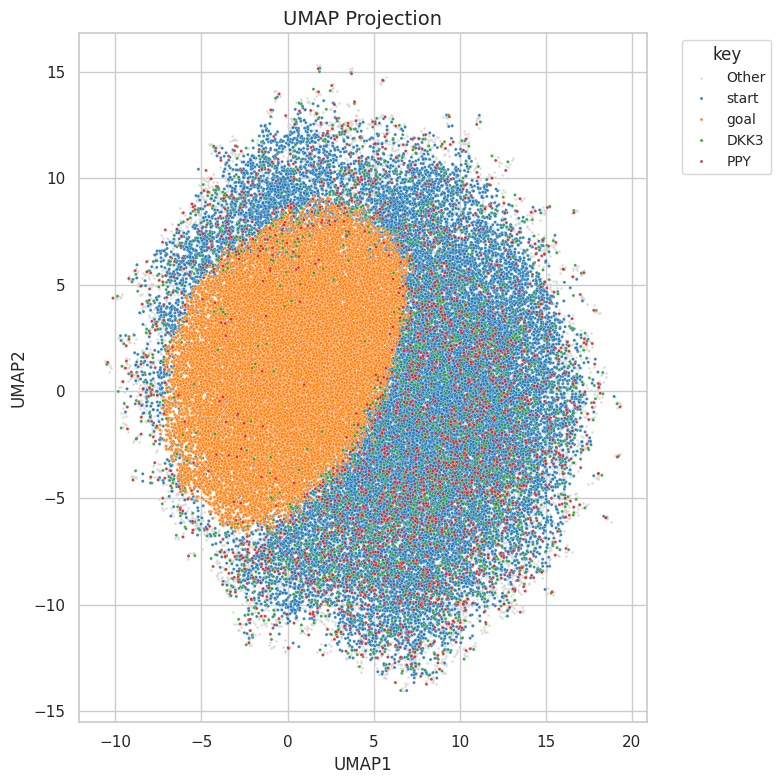

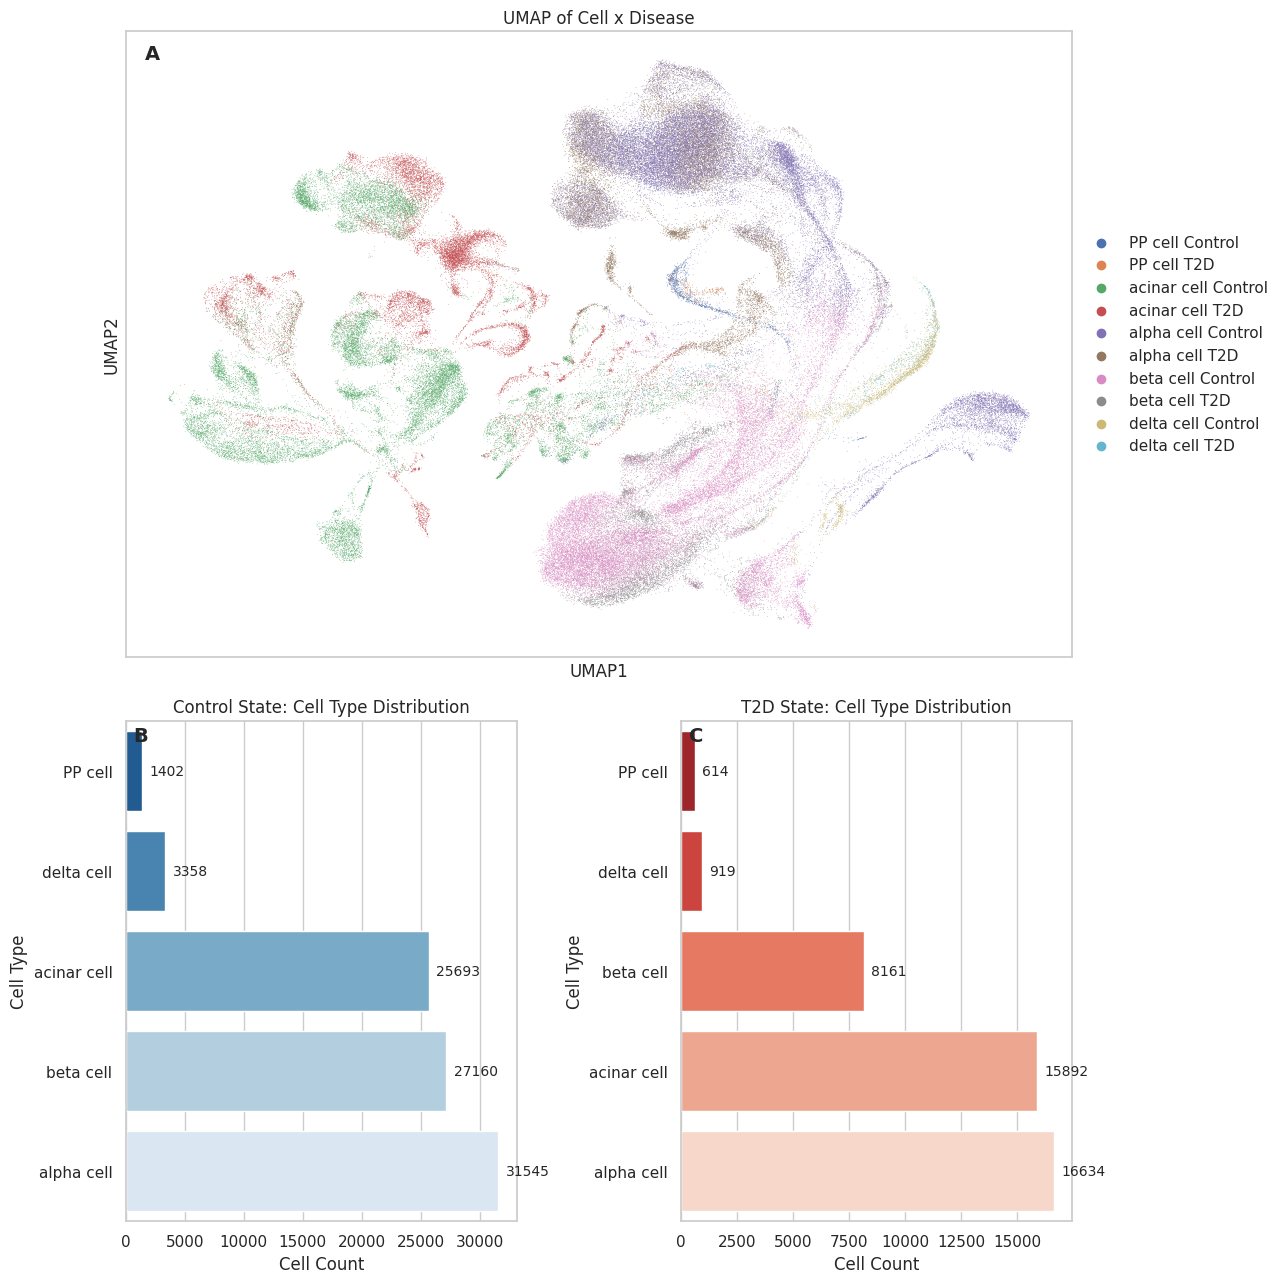

In [30]:

propagated_cells=generate_examples(adata=adata,
                                 stargan=stargan,
                                 oracle=oracle,
                                 propagator=propagator,
                                 shared_filter=shared_filter,
                                 filter_criteria_start=filter_criteria_start,
                                 filter_criteria_goal=filter_criteria_goal,
                                 device=device,cells_to_generate=2000,
                                 top_genes=list(perturbation_metrics.sort_values("oracle_score",ascending=False).head(3)['label'])+list(perturbation_metrics.sort_values("oracle_score",ascending=False).tail(3)['label'])+["PPY","DKK3"],
                                 latent=False
                                 )

print(propagated_cells.shape)
umap_data=pca_umap_transform(dataframe=propagated_cells, key_column='key', n_pca_components=25, n_umap_components=2, n_neighbors=5, min_dist=1)

plot_umap(
    dataframe=umap_data,
    key_column="key",
    highlight_keys=["PPY","INS","DKK3"]+['start','goal'],  # Highlight key1 and key2
    figsize=(8, 8),
    default_color="lightgray",
)


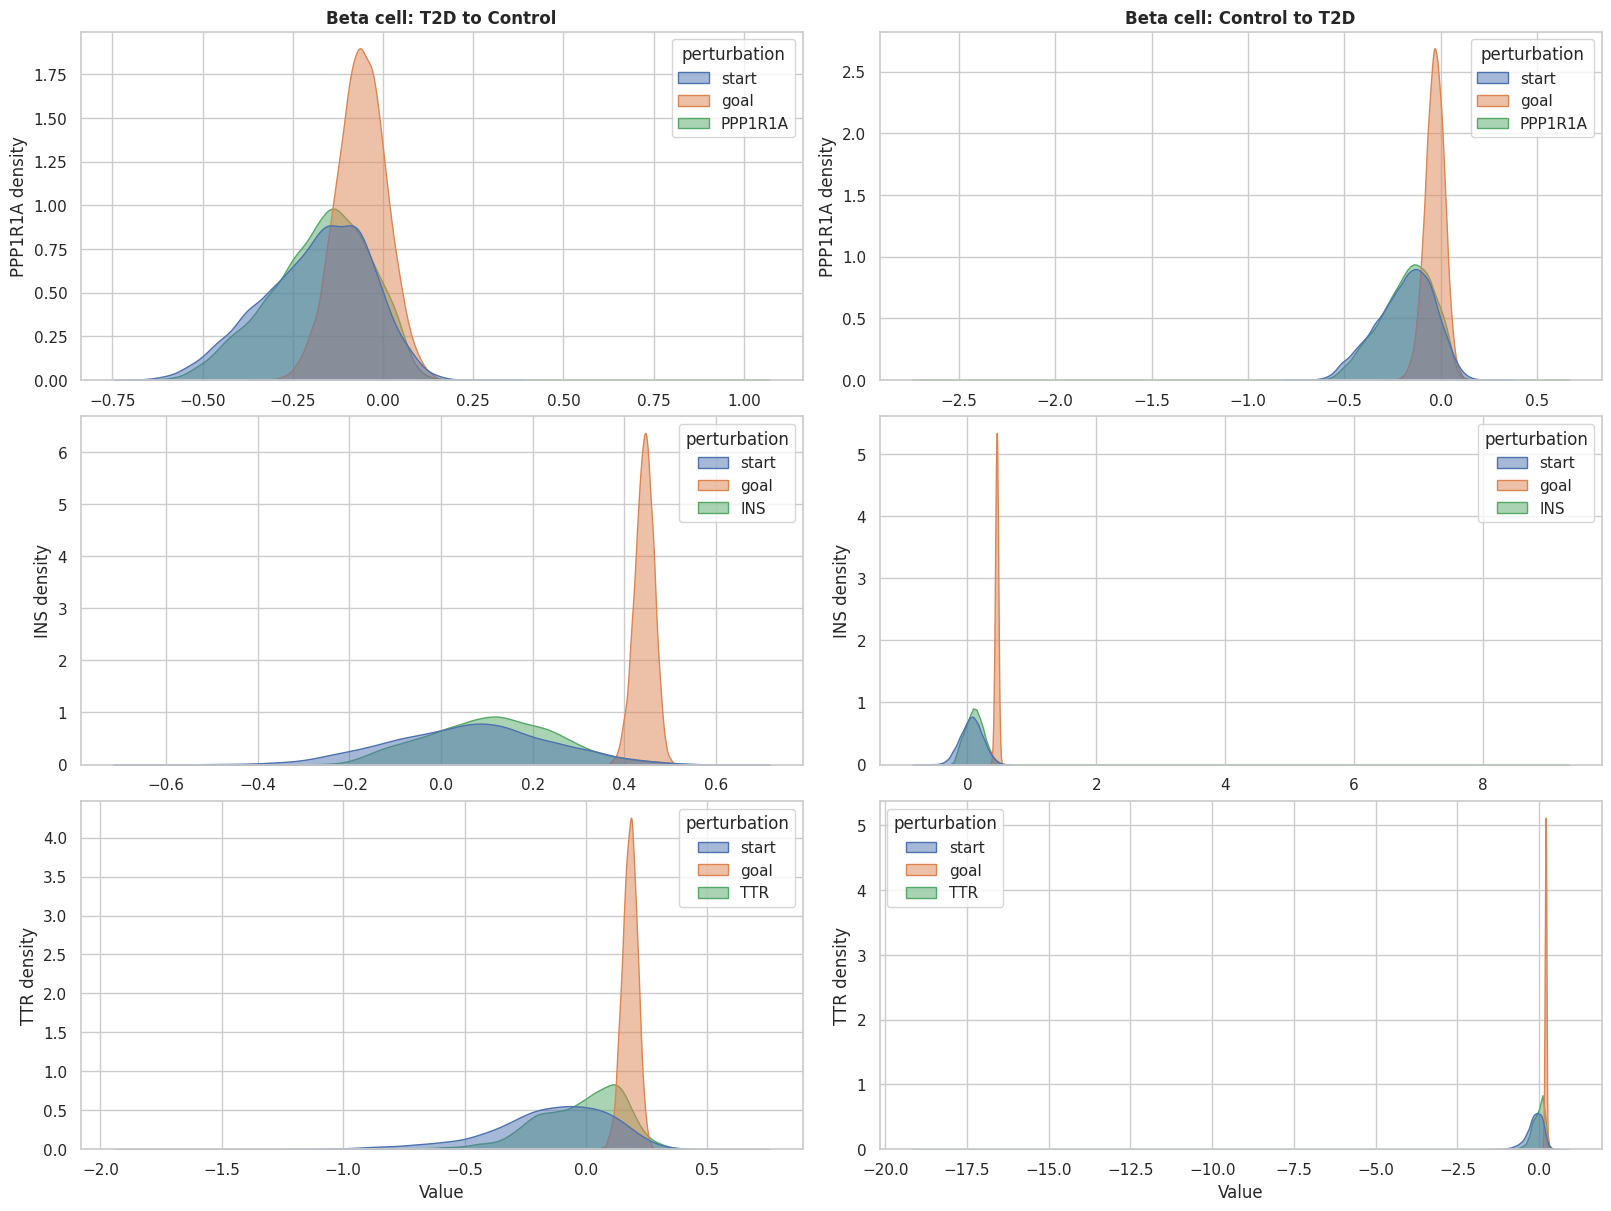

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_density(df, value_col, category_col):
    """
    Plots a density plot for a numerical column in a DataFrame,
    with colors assigned based on a categorical column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    value_col (str): The name of the numerical column to plot.
    category_col (str): The name of the categorical column for coloring.

    Returns:
    None
    """
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=value_col, hue=category_col, fill=True, alpha=0.5)
    
    # Labels and title
    plt.xlabel(value_col)
    plt.ylabel("Density")
    plt.title(f"Density Plot of {value_col} by {category_col}")
    # Show the plot
    plt.show()


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_density_grid(df1, df2, value_cols, category_col, figsize=(16, 12), title1="Title 1", title2="Title 2"):
    """
    Plots a side-by-side grid of density plots for multiple numerical columns in two DataFrames,
    with colors assigned based on a categorical column.

    Parameters:
    df1 (pd.DataFrame): The first input DataFrame.
    df2 (pd.DataFrame): The second input DataFrame.
    value_cols (list): List of numerical column names to plot.
    category_col (str): The categorical column for coloring.
    figsize (tuple): Size of the overall figure.
    title1 (str): Title for the first dataset plots.
    title2 (str): Title for the second dataset plots.

    Returns:
    None
    """
    rows = len(value_cols)  # One row per gene
    fig, axes = plt.subplots(rows, 2, figsize=figsize, constrained_layout=True)

    for i, value_col in enumerate(value_cols):
        # First column (df1)
        sns.kdeplot(
            data=df1[df1[category_col].isin(["start", "goal", value_col])], 
            x=value_col, hue=category_col, fill=True, alpha=0.5, ax=axes[i, 0]
        )
        axes[i, 0].set_xlabel("")
        axes[i, 0].set_ylabel(value_col+" density")
        if i == 0:
            axes[i, 0].set_title(title1, fontweight="bold")

        # Second column (df2)
        sns.kdeplot(
            data=df2[df2[category_col].isin(["start", "goal", value_col])], 
            x=value_col, hue=category_col, fill=True, alpha=0.5, ax=axes[i, 1]
        )
        axes[i, 1].set_xlabel("")
        axes[i, 1].set_ylabel(value_col+" density")
        if i == 0:
            axes[i, 1].set_title(title2, fontweight="bold")
    axes[ len(value_cols)-1,0].set_xlabel("Value")
    axes[ len(value_cols)-1,1].set_xlabel("Value")
    plt.show()
    return fig


# Gene list
gene_viz_set = ["PPP1R1A", "INS",'TTR']


# Generate first set of propagated cells (Control to T2D)
propagated_cells_1 = generate_examples(
    adata=adata,
    stargan=stargan,
    oracle=oracle,
    propagator=propagator,
    shared_filter=shared_filter,
    filter_criteria_start=filter_criteria_start,
    filter_criteria_goal=filter_criteria_goal,
    device=device,
    cells_to_generate=None,
    top_genes=gene_viz_set,
    latent=False
)
propagated_cells_1.columns = list(adata.var.index.copy()) + ["perturbation"]

# Generate second set of propagated cells (T2D to Control)
propagated_cells_2 = generate_examples(
    adata=adata,
    stargan=stargan,
    oracle=oracle,
    propagator=propagator,
    shared_filter=shared_filter,
    filter_criteria_start=filter_criteria_goal,
    filter_criteria_goal=filter_criteria_start,
    device=device,
    cells_to_generate=None,
    top_genes=gene_viz_set,
    latent=False
)
propagated_cells_2.columns = list(adata.var.index.copy()) + ["perturbation"]


# Plot both conditions side by side
densities=plot_density_grid(
    propagated_cells_2, 
    propagated_cells_1, 
    gene_viz_set, 
    "perturbation",
    title2="Beta cell: Control to T2D",
    title1="Beta cell: T2D to Control"
)

densities.savefig(f'{main_path}{single_cell_data}/densities_curated.png')

In [32]:
umap_data

UMAP1      UMAP2    key
0      10.705424   0.597248  start
1       1.863935   8.864689  start
2      -6.816591  -0.011875  start
3      13.386417   3.395229  start
4      11.155788   1.941686  start
...          ...        ...    ...
70315   7.487010   8.330969    TTR
70316  -3.473317  -8.920669    TTR
70317   7.165833   3.734562    TTR
70318  19.148609  -3.044658    TTR
70319   5.199983 -12.972852    TTR

[70320 rows x 3 columns]

(60320, 929)


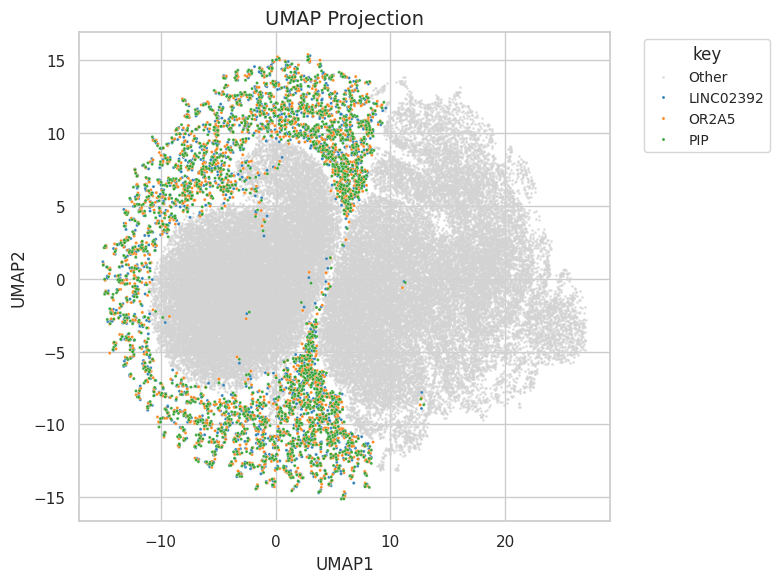

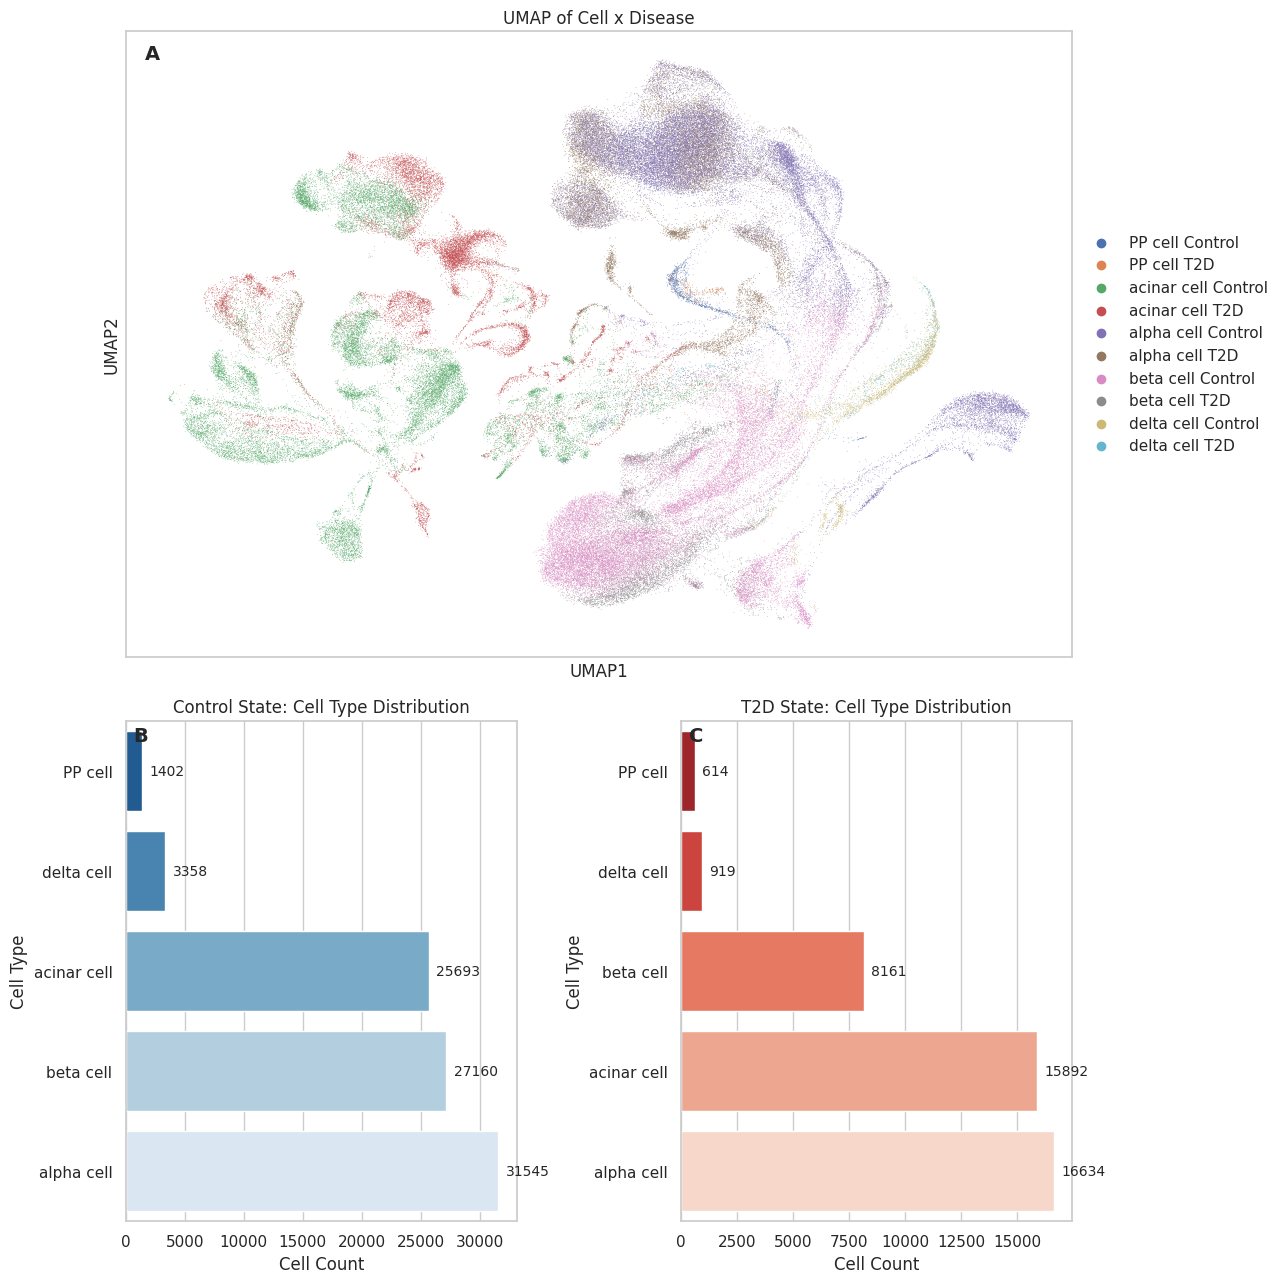

In [33]:

propagated_cells=generate_examples(adata=adata,
                                 stargan=stargan,
                                 oracle=oracle,
                                          propagator=propagator,
                                          shared_filter=shared_filter,
                                 filter_criteria_start=filter_criteria_start,
                                 filter_criteria_goal=filter_criteria_goal,
                                 device=device,cells_to_generate=2000,
                                   top_genes=list(perturbation_metrics.sort_values("oracle_score",ascending=False).tail(3)['label']),
                                   latent=True
                                  )

print(propagated_cells.shape)
umap_data=pca_umap_transform(dataframe=propagated_cells, key_column='key', n_pca_components=25, n_umap_components=2, n_neighbors=5, min_dist=1)

plot_umap(
    dataframe=umap_data,
    key_column="key",
    highlight_keys=list(perturbation_metrics.sort_values("oracle_score",ascending=False).tail(3)['label'])+['start_prop','goal_prop'],  # Highlight key1 and key2
    figsize=(8, 6),
    default_color="lightgray",
)

(60320, 3001)


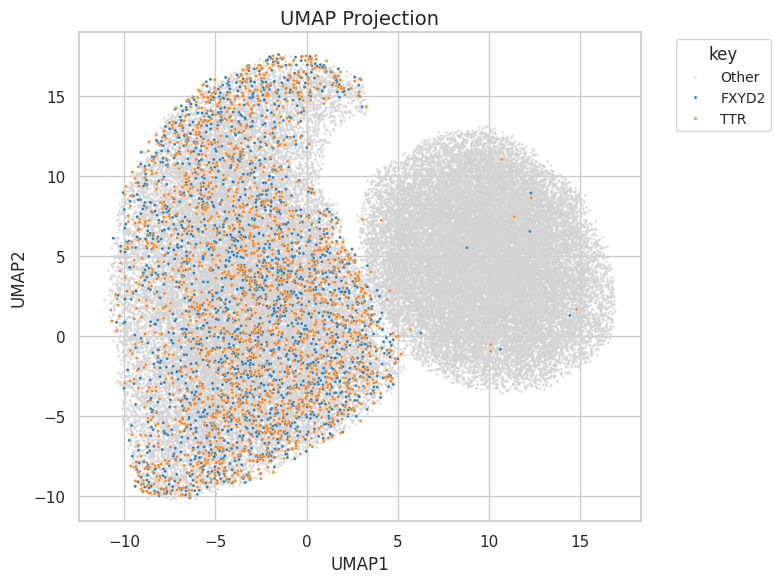

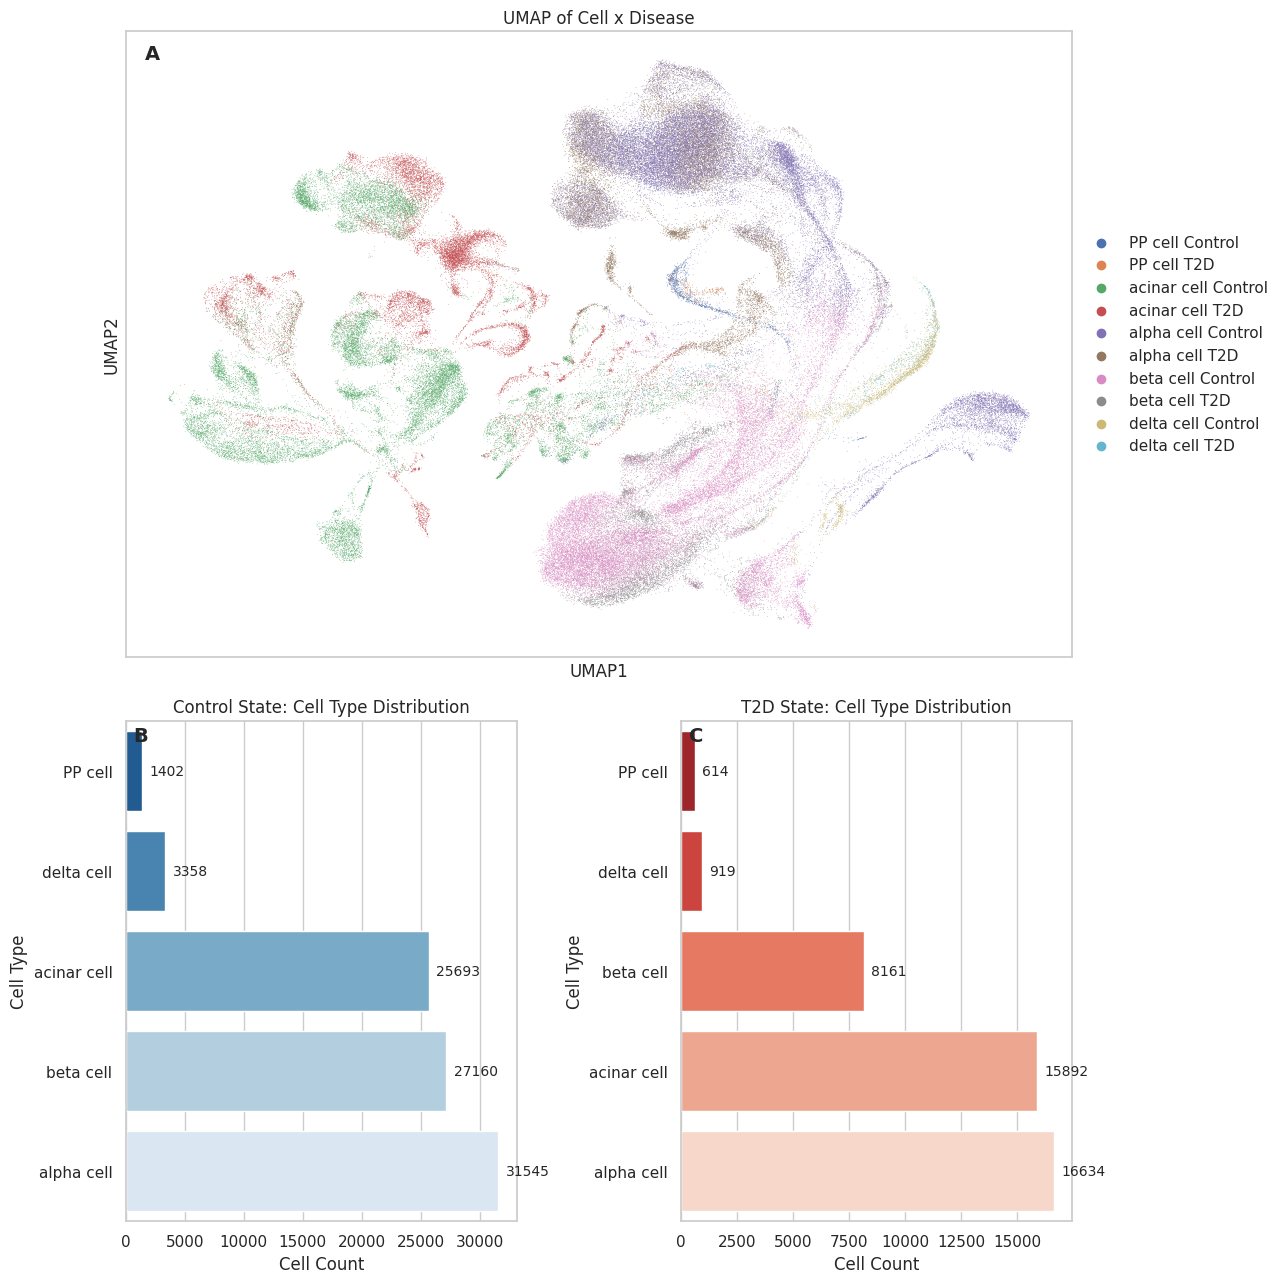

In [34]:
propagated_cells=generate_examples(adata=adata,
                                 stargan=stargan,
                                 oracle=oracle,
                                          propagator=propagator,
                                          shared_filter=shared_filter,
                                 filter_criteria_start=filter_criteria_start,
                                 filter_criteria_goal=filter_criteria_goal,
                                 device=device,cells_to_generate=2000,
                                   top_genes=list(perturbation_metrics.sort_values("oracle_score",ascending=False).head(3)['label']),
                                   latent=False
                                  )

print(propagated_cells.shape)
umap_data=pca_umap_transform(dataframe=propagated_cells, key_column='key', n_pca_components=25, n_umap_components=2, n_neighbors=10, min_dist=1)

plot_umap(
    dataframe=umap_data,
    key_column="key",
    highlight_keys=list(perturbation_metrics.sort_values("oracle_score",ascending=False).head(2)['label'])+['start_prop','goal_prop'],  # Highlight key1 and key2
    figsize=(8, 6),
    default_color="lightgray",
)

In [35]:
'''
# Horizontal bar plot
pm=perturbation_metrics.sort_values('oracle_score',ascending=False)#.tail(100)
import matplotlib.pyplot as plt

# Create the scatter plot with transparency
plt.figure(figsize=(20, 8))
plt.scatter(x=pm['label'], y=pm['oracle_score'], alpha=0.3, color='blue', s=10)

# Add title and labels
plt.title("Scores of 2000 Individuals", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Oracle Score", fontsize=14)
plt.xticks(rotation=90)
plt.axhline(y=0.0,linewidth=1, color='red')
# Improve layout
plt.tight_layout()
plt.grid(False)
# Show the plot
plt.show()

'''

'\n# Horizontal bar plot\npm=perturbation_metrics.sort_values(\'oracle_score\',ascending=False)#.tail(100)\nimport matplotlib.pyplot as plt\n\n# Create the scatter plot with transparency\nplt.figure(figsize=(20, 8))\nplt.scatter(x=pm[\'label\'], y=pm[\'oracle_score\'], alpha=0.3, color=\'blue\', s=10)\n\n# Add title and labels\nplt.title("Scores of 2000 Individuals", fontsize=16)\nplt.xlabel("Label", fontsize=14)\nplt.ylabel("Oracle Score", fontsize=14)\nplt.xticks(rotation=90)\nplt.axhline(y=0.0,linewidth=1, color=\'red\')\n# Improve layout\nplt.tight_layout()\nplt.grid(False)\n# Show the plot\nplt.show()\n\n'